In [26]:
%load_ext autoreload
%autoreload 2

import pyVHR as vhr
import numpy as np
from pyVHR.analysis.pipeline import Pipeline
from pyVHR.plot.visualize import *
import os
import plotly.express as px
from pyVHR.utils.errors import getErrors, printErrors, displayErrors
from pyVHR.extraction.utils import CustomLandm3arks
import pyVHR.analysis.pipelineLandmarks as custom_pipeline

import constants
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
        
vhr.plot.VisualizeParams.renderer = 'vscode' 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
all_landmarks = list(CustomLandmarks().get_all_landmarks().keys())

PALETTE = 'Set3'

# Functions

In [67]:
def format_data(df, metric):
    """
        Add video setting and person columns to the dataframe
        Convert the metric column from list to single float
    """
     # Video setting: gym, still, ...    
    df['video'] = np.where(df['dataset'] == 'mr_nirp',df['videoFilename'].apply(lambda x: x.split('_')[1]),
                       np.where(df['dataset'] == 'lgi_ppgi',df['videoFilename'].apply(lambda x: x.split('_')[-1]),
                        None))
    # Person: Subject2 (MR_NIRP), alex (LGI_PPGI), ...
    df['person'] = np.where(df['dataset'] == 'mr_nirp',df['videoFilename'].apply(lambda x: x.split('_')[0]),
                    np.where(df['dataset'] == 'lgi_ppgi',df['videoFilename'].apply(lambda x: x.split('_')[0]),
                    None))
    if df[metric].dtype == 'object':
        df[metric] = df[metric].apply(lambda x: x[0])
        if metric == 'PCC':
            df[metric] = df[metric].abs()

    return df

def get_data_each_landmark(df, metric, dataset_name):
    ### Get data
    if type(df['landmarks'].iloc[0]) != str: # landmarks are symmetric
        df['landmarks'] = df['landmarks'].apply(lambda x: x[0] if 'left' not in x[0] else '_'.join(x[0].split('_')[1:]))
    df = format_data(df, metric)

    return df

def get_palette(df, hue='landmarks_id'):
    # Defining the color palette
    palette = sns.color_palette(PALETTE, n_colors=len(df[hue].unique()))
    palette = dict(zip(df[hue].unique(), palette))
    return palette

def plot_boxplot_each_landmark(df, metric, dataset_name, ax=None):
    # Determin median metric order
    grouped = df[['landmarks', metric]].groupby('landmarks').mean().sort_values(by=metric)
    palette = get_palette(df, hue='landmarks')

    if ax is None:
        ax = plt.gca()
    box = sns.boxplot(x='landmarks', y=metric, data=df, order=grouped.index, palette=palette, hue='landmarks', legend='brief', ax=ax)
    box.legend_.remove()
    labels = [item.get_text().replace('_', ' ')  for item in box.get_xticklabels()]
    box.set_xticks(range(len(labels)))
    box.set_xticklabels(labels,rotation=90, fontsize=7)
    box.set_title(f"Boxplot of average MAE for individual landmarks ({dataset_name.upper()})")

    return grouped, box

def plot_histogram_each_landmark(df, metric, dataset_name, ax=None):
    # Determin median metric order
    rankings = df.groupby('videoFilename')[metric].rank(ascending=True).groupby(df['landmarks']).mean().sort_values().reset_index()
    palette = get_palette(df, hue='landmarks')
    
    if ax is None:
        ax = plt.gca()
    bar = sns.barplot(x='landmarks', y=metric, data=rankings, palette=palette, hue='landmarks', ax=ax)
    labels = [item.get_text().replace('_', ' ')  for item in ax.get_xticklabels()]
    bar.set_xticks(range(len(labels)))
    bar.set_xticklabels(labels, rotation=90, fontsize=6)
    bar.set_title(f"Average rankings of the MAE values for individual landmarks ({dataset_name.upper()})")

    return rankings, bar

def plot_each_landmark(df, metric, dataset_name, axs=None):
    if axs is None:
        fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    df = get_data_each_landmark(df, metric, dataset_name)
    grouped, box = plot_boxplot_each_landmark(df, metric, dataset_name, axs[0])
    rankings, bar = plot_histogram_each_landmark(df, metric, dataset_name, axs[1])

    return df, grouped, rankings, box, bar

In [29]:
def get_handle_labels(df, axes, redundant=False):
    """
        From landmarks_ids (0,1,...) to landmarks names (forehead, nose, ...)
    """
    landamarks_mapping = df[['landmarks','landmarks_id']].drop_duplicates().sort_values(by='landmarks_id')
    if type(landamarks_mapping['landmarks'][0]) == tuple:
        landmarks_names = [', '.join([name.replace('_', ' ') for name in names]) for names in landamarks_mapping['landmarks'].values]
    else:
        landmarks_names = [name.replace('_', ' ') for name in landamarks_mapping['landmarks'].values]
    landamarks_mapping = dict(zip(landamarks_mapping['landmarks_id'].values, landmarks_names))

    if redundant:
        handles_labels = [ax.get_legend_handles_labels() for ax in axes]
        handles = [None] * len(df['landmarks_id'].unique())
        labels = [None] * len(df['landmarks_id'].unique())
        for (handle_label) in handles_labels:
            for i,(h,l) in enumerate(zip(*handle_label)):
                if  handles[int(l)] is None:
                    handles[int(l)] = h
                    labels[int(l)] = l+'. '+str(landamarks_mapping[int(l)])
    else:
        handles, labels = axes.get_legend_handles_labels()
        for i,(h,l) in enumerate(zip(handles, labels)):
            if i == 0:
                labels[i] = 'Landmarks'
            if l.isdigit(): # check the label is a landmarks_id digit (not a label)
                labels[i] = l+'. '+str(landamarks_mapping[int(l)])
            if i > len(df['landmarks_id'].unique()):
                break
                
    return handles, labels

def get_rankings_roi(df, dataset_name, metric='MAE'):
    if df[metric].dtype == 'object':
        df[metric] = df[metric].apply(lambda x: x[0])
    if dataset_name == 'MR_NIRP':
        df['video'] = df.videoFilename.apply(lambda x: x.split('_')[1])
    if dataset_name == 'LGI_PPGI':
        df['video'] = df['videoFilename'].apply(lambda x: x.split('_')[-1])
    df['score'] = df.groupby(['video','landmarks']).MAE.transform('mean')
    df = df.reset_index(drop=True)

    # rankings = df.sort_values(['video','score']).drop_duplicates(['video','score']).groupby(['video']).head(5) # take top 5 landmarks per video
    rankings = df.sort_values(['video','score']).drop_duplicates(['video','score']) # take all landmarks
    rankings['landmarks_id'] = rankings['landmarks'].astype('category').cat.codes
    rankings = rankings[['video', 'videoIdx', 'landmarks','landmarks_id','MAE', 'RMSE', 'PCC','score']]\
                        .reset_index(drop=True)

    return df, rankings

def plot_bar_roi(df, rankings, roi, dataset_name, ncol=1, fig=None, axs=None):

    if fig is None:
        fig, axs = plt.subplots(1,len(df.video.unique()), figsize=(15,5))

    palette = get_palette(rankings, 'landmarks_id')
    for i,ax in zip(range(len(df.video.unique())), axs.ravel()):
        video = df.video.unique()[i]
        df_video = rankings[rankings.video==video]
        bar = sns.barplot(x='landmarks_id', y='score', data=df_video, ax=ax, hue='landmarks_id', palette=palette)
        for container in ax.containers:
            bar.bar_label(container, fmt='%.1f', padding=-15)
        bar.set(xlabel=None, ylabel=None)
        if i < len(df.video.unique()) - 2:
            bar.set(xlabel=None, ylabel=None, xticks=[])
        bar.legend_.remove()
        bar.set_title(video)
    fig.supxlabel("Landmarks ID")
    fig.supylabel("Average MAE", x= 0.08)
    fig.suptitle(f"Landmarks with highest average MAE per video category for ROI = {roi} ({dataset_name}))")
    handles, labels = get_handle_labels(rankings, fig.axes, redundant=True)
    fig.legend(handles,labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=1)

    return fig, axs

def add_median_labels(ax, medians, fmt=".1f") -> None:
    # vertical_offset = df_video['MAE'].median() * 0.03 # offset from median for display
    lines = ax.get_lines()
    for i,xtick in enumerate(ax.get_xticks()):
        text = ax.text(xtick, medians.iloc[xtick], medians.iloc[xtick], color='white',
                        horizontalalignment='center', verticalalignment='center', fontsize=9) # color='b',weight='semibold' size='x-small'
        # create median-colored border around white text for contrast
        ## I dont know why it doesnt work without this
        if lines[i].get_color() == 'black':
            print("Median label: change from black to grey")
            lines[i].set_color((0.3847058823529411, 0.3847058823529411, 0.3847058823529411))
        text.set_path_effects([
            path_effects.Stroke(linewidth=2, foreground=lines[i].get_color()),
            path_effects.Normal(),
        ])

        # ax.text(xtick, medians[xtick] + vertical_offset, medians[xtick], 
        #         horizontalalignment='center', size='x-small') # color='b',weight='semibold'

def plot_box_roi(df, rankings, roi, dataset_name, ncol=1, fig=None, axs=None):
    
    if fig is None:
        fig, axs = plt.subplots(1,len(df.video.unique()), figsize=(15,5))

    df['landmarks_id'] = df['landmarks'].astype('category').cat.codes
    palette = get_palette(df,'landmarks_id')
    for i,ax in zip(range(len(df.video.unique())), axs.ravel()):
        video = df.video.unique()[i]
        landmarks_ids = rankings[rankings.video==video]['landmarks_id']
        df_video = df[df.video==video].query('landmarks_id in @landmarks_ids')
        ax = sns.boxplot(x='landmarks_id', y='MAE', data=df_video, ax=ax, hue='landmarks_id', palette=palette)
        ax.set(xlabel=None, ylabel=None)
        ax.legend_.remove()
        ax.set_title(video)

        medians = df_video.groupby(['landmarks_id'])['MAE'].median().round(2)
        add_median_labels(ax, medians)
        if i < len(df.video.unique()) - 2:
            ax.set(xlabel=None, ylabel=None, xticks=[])
    fig.supxlabel("Landmarks ID")
    fig.supylabel("MAE", x= 0.08)
    fig.suptitle(f"Landmarks with highest average MAE per video category for ROI = {roi} ({dataset_name})")
    handles, labels = get_handle_labels(rankings, fig.axes, redundant=True)
    fig.legend(handles,labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=1)

    return fig, axs

def plot_bubble_roi(df, metric, dataset_name, roi, title=None, size=[1200,400]):

    df = df.copy()
    if df[metric].dtype == 'object':
        df[metric] = df[metric].apply(lambda x: x[0])
    if dataset_name == 'MR_NIRP':
        df['video'] = df.videoFilename.apply(lambda x: x.split('_')[1])
    if dataset_name == 'LGI_PPGI':
        df['video'] = df['videoFilename'].apply(lambda x: x.split('_')[-1])
    df['ldmk_time'] = df.groupby('landmarks')['TIME_REQUIREMENT'].transform('sum')
    df['ldmk_MAE'] = df.groupby('landmarks')['MAE'].transform('mean')
    df['ldmk_size'] = df['landmarks'].apply(lambda x: len(x))
    if len(df.loc[0,'ROI'].split('_'))> 1: # testing combination of ROIs
        df['landmarks'] = df['ROI'].apply(lambda x: ', '.join((x.split('_'))))
        # df['landmarks'] = df['dataset'].apply(lambda x: ', '.join((x.split('_')[2:])))
    else: # testion single ROI and multiple landmarks
        df['landmarks'] = df.landmarks.apply(lambda x: ', '.join(x).replace('_',' ').replace('(','').replace(')',''))    
    df['landmarks_id'] = df['landmarks'].astype('category').cat.codes
    df['landmarks'] = df['landmarks_id'].astype('str') + ': ' + df['landmarks'] 
    df = df.sort_values(by='landmarks_id').reset_index(drop=True)
    
    fig = px.scatter(df, x="ldmk_time", y="ldmk_MAE", color="landmarks", size='ldmk_size', hover_data=['landmarks'], text='landmarks_id',
                    template='none', color_discrete_sequence=px.colors.qualitative.Set2, width=size[0], height=size[1],
                    labels={'ldmk_time':'Time requirement (s)', 'ldmk_MAE':'MAE (bpm)', 'landmarks':'Landmarks', 'ldmk_size':'Number of landmarks'},
                    title=f"MAE vs Time requirement for each landmark ({dataset_name.upper()} {roi if roi is not None else })",) 
    fig.update_traces(textposition='middle center', textfont_size=12, textfont_family='Courier New') 
    fig.update_xaxes(showline=True, linecolor='black', mirror=True) # linewidth=2, 
    fig.update_yaxes(showline=True, linecolor='black', mirror=True)
    if title is not None:
        fig.update_layout(title_text=title)
    return df, fig

# LGI-PPGI

In [30]:
# -- LOAD A DATASET

dataset_name = 'LGI_PPGI'    
video_DIR, BVP_DIR = constants.get_dataset_paths(dataset_name)

dataset = vhr.datasets.datasetFactory(dataset_name, videodataDIR=video_DIR, BVPdataDIR=BVP_DIR)
allvideo = dataset.videoFilenames
wsize = 8        # seconds of video processed (with overlapping) for each estimate 
fps = vhr.extraction.get_fps(dataset.getSigFilename(0))

# print the list of video names with the progressive index (idx)
for v in range(len(allvideo)):
  print(v, allvideo[v])

0 D:/datasets_rppg/LGI_PPGI\alex\alex_gym\cv_camera_sensor_stream_handler.avi
1 D:/datasets_rppg/LGI_PPGI\alex\alex_resting\cv_camera_sensor_stream_handler.avi
2 D:/datasets_rppg/LGI_PPGI\alex\alex_rotation\cv_camera_sensor_stream_handler.avi
3 D:/datasets_rppg/LGI_PPGI\alex\alex_talk\cv_camera_sensor_stream_handler.avi
4 D:/datasets_rppg/LGI_PPGI\angelo\angelo_gym\cv_camera_sensor_stream_handler.avi
5 D:/datasets_rppg/LGI_PPGI\angelo\angelo_resting\cv_camera_sensor_stream_handler.avi
6 D:/datasets_rppg/LGI_PPGI\angelo\angelo_rotation\cv_camera_sensor_stream_handler.avi
7 D:/datasets_rppg/LGI_PPGI\angelo\angelo_talk\cv_camera_sensor_stream_handler.avi
8 D:/datasets_rppg/LGI_PPGI\cpi\cpi_gym\cv_camera_sensor_stream_handler.avi
9 D:/datasets_rppg/LGI_PPGI\cpi\cpi_resting\cv_camera_sensor_stream_handler.avi
10 D:/datasets_rppg/LGI_PPGI\cpi\cpi_rotation\cv_camera_sensor_stream_handler.avi
11 D:/datasets_rppg/LGI_PPGI\cpi\cpi_talk\cv_camera_sensor_stream_handler.avi
12 D:/datasets_rppg/LGI_

## Boxplot by landmark

In [64]:
fig = px.line(x=x['timeGT'], y=x['bpmGT'], labels={'x': 'Time', 'y': 'GT'}, title='BPM vs Time')
fig.add_trace(px.line(x=x['timeES'], y=x['bpmES']).data[0].update(line_color='red', name='BPM (ES)'))
fig.show()

Reding  ../results/test_landmarks/h5/LGI_PPGI/LGI_PPGI_each_landmark.h5


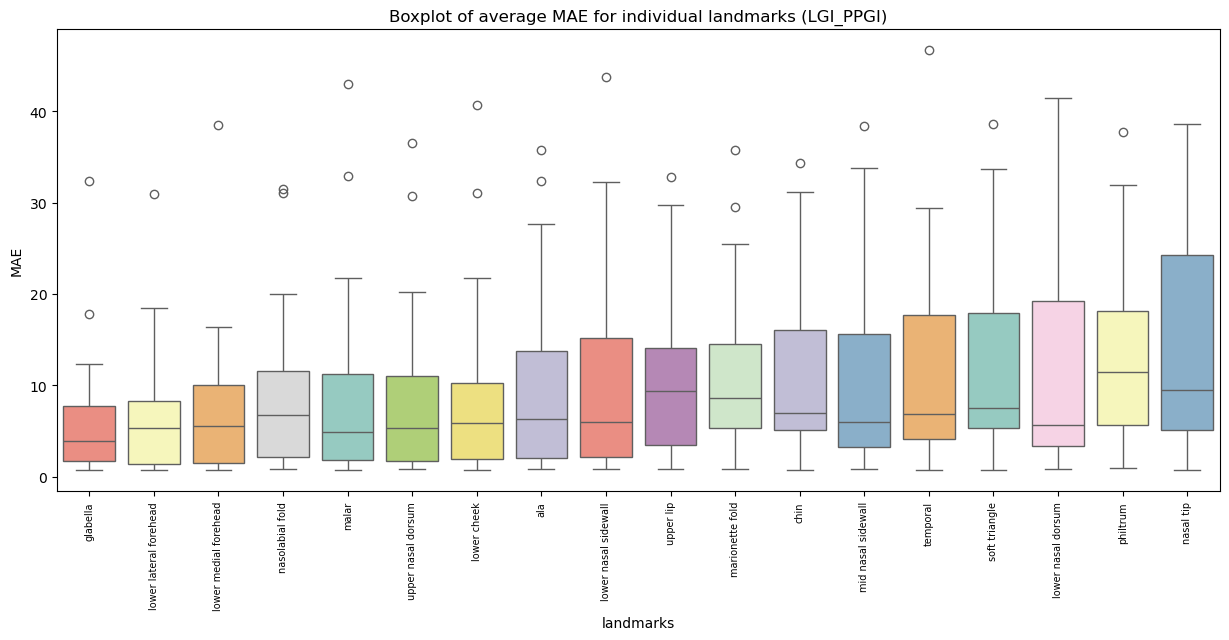

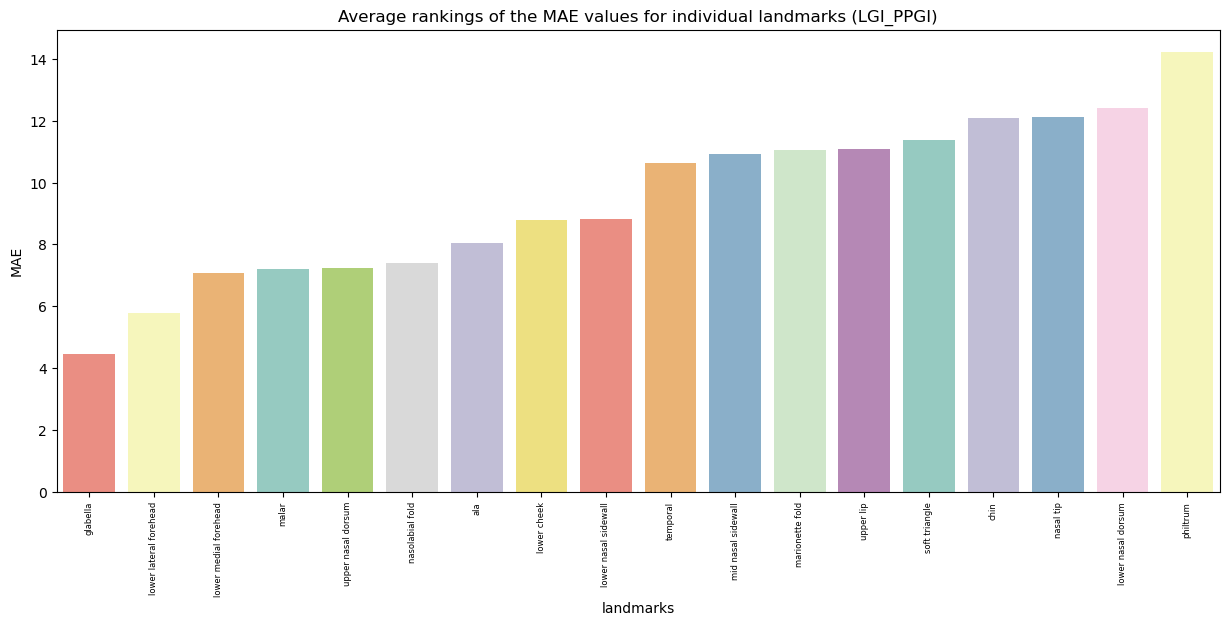

In [65]:
filenameH5 = f"../results/test_landmarks/h5/{dataset_name}/" + f"{dataset_name}_each_landmark" + ".h5"
metric = 'MAE'

print("Reding ", filenameH5)

df =  pd.read_hdf(filenameH5)
_, ax1 = plt.subplots(1,1, figsize=(15,6))
_, ax2 = plt.subplots(1,1, figsize=(15,6))
df, grouped, rankings, box, bar = plot_each_landmark(df, metric, dataset_name, [ax1,ax2])

# df = df.query('person != "felix"')
# print("I am taking out felix videos because fuck them")
# df = df.query('video != "gym"')
# print("I am taking out gym videos because fuck them")

In [7]:
# Worst performing video on each video setting
df.query("landmarks == 'glabella'").query('method == "cupy_CHROM"').sort_values('MAE', ascending=False).groupby('video').head(1)

,method,dataset,videoFilename,videoIdx,RMSE,MAE,PCC,CCC,SNR,MAX,...,DTW,bpmGT,bpmES,timeGT,timeES,TIME_REQUIREMENT,landmarks,ROI,video,person
84,cupy_CHROM,lgi_ppgi,harun_gym,20,[42.80714367317885],32.397053,[-0.07442693095141334],[-0.03090422630544887],[-5.070012055500783],[107.54296875],...,None,"[99.5, 99.0, 98.5, 100.0, 102.5, 105.0, 105.5,...","[54.931640625, 55.2978515625, 57.12890625, 78....","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",170.565923,glabella,forehead,gym,harun
76,cupy_CHROM,lgi_ppgi,cpi_talk,11,[20.23307701007192],17.823664,[0.18742090091012117],[0.05505452028612498],[-3.9550230718167447],[37.892578125],...,None,"[71.0, 72.0, 73.5, 76.5, 80.5, 85.5, 89.5, 90....","[54.931640625, 55.2978515625, 89.35546875, 87....","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",45.051903,glabella,forehead,talk,cpi
86,cupy_CHROM,lgi_ppgi,harun_rotation,22,[16.010701405515054],10.690833,[0.24877433478585753],[0.06151786089665611],[-1.1344514451255756],[35.2236328125],...,None,"[87.5, 88.5, 90.5, 91.5, 90.5, 88.0, 85.0, 82....","[90.8203125, 89.35546875, 87.158203125, 83.496...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",39.893173,glabella,forehead,rotation,harun
81,cupy_CHROM,lgi_ppgi,felix_resting,17,[5.566763594865538],5.109918,[0.05593953167019054],[0.006516580670828737],[14.234547471952817],[11.08984375],...,None,"[56.0, 55.0, 53.5, 52.0, 51.5, 51.5, 51.5, 51....","[47.2412109375, 47.607421875, 47.607421875, 47...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",39.317832,glabella,forehead,resting,felix


## Individual landmarks by video setting

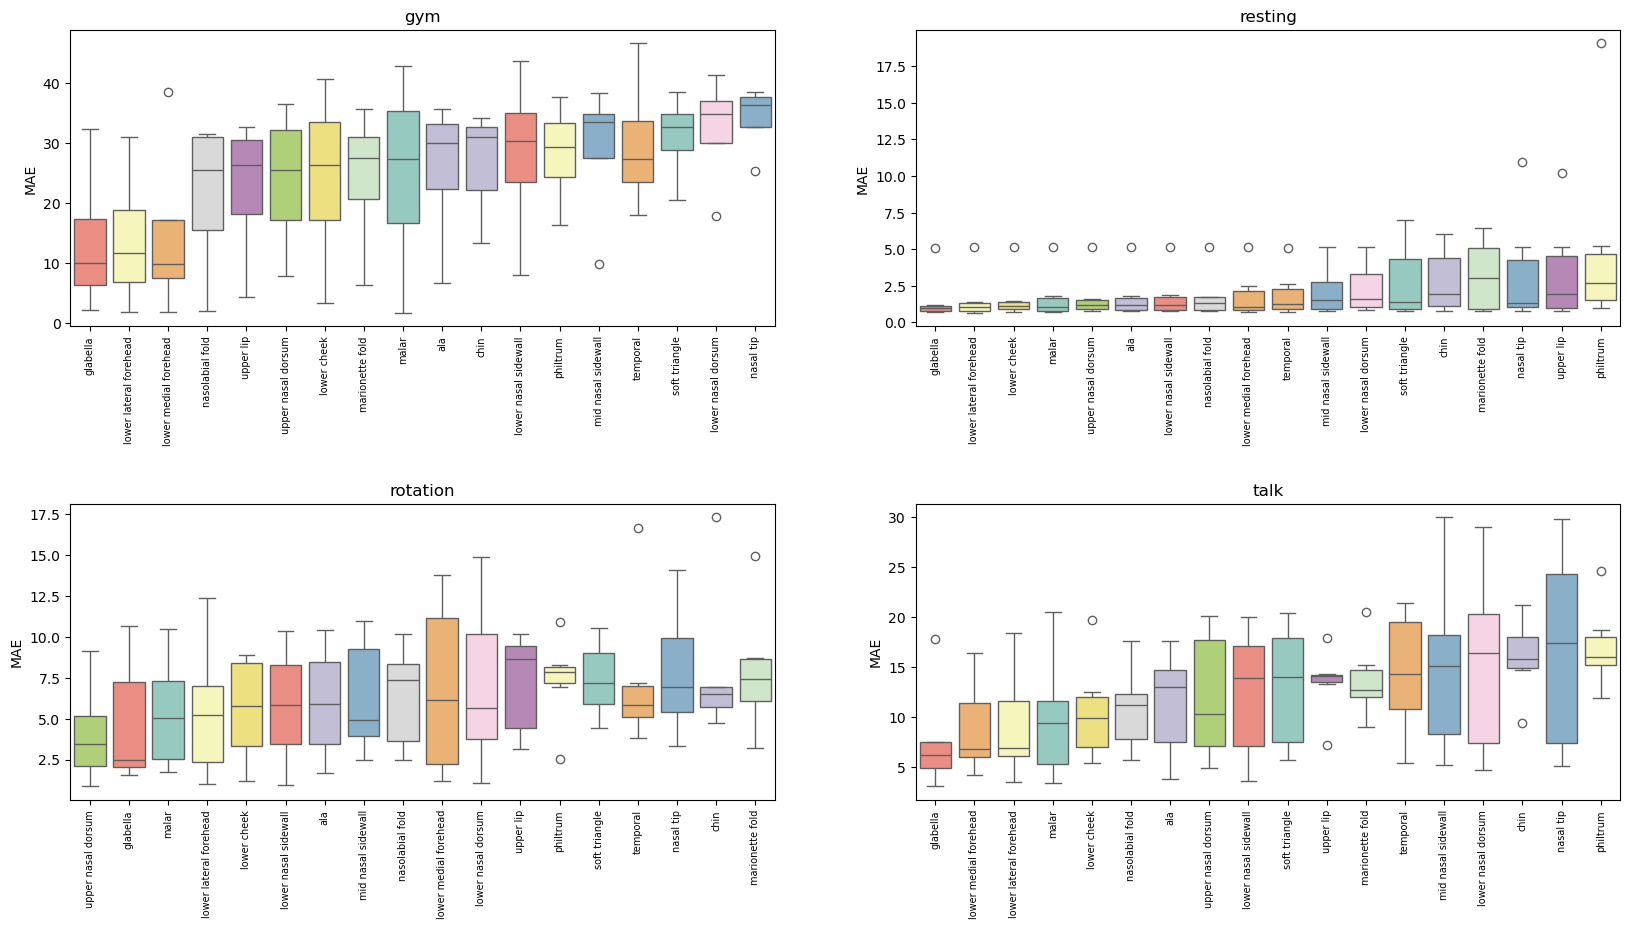

In [13]:
fig, axs = plt.subplots(2,2, figsize=(20,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.6)
# fig.tight_layout()
videos = df.video.unique()
for i,ax in zip(range(len(df.video.unique())), axs.ravel()):
   df_video = df.loc[df['video'] == videos[i]].copy()
   df_video = get_data_each_landmark(df_video, metric, dataset_name)
   _, box = plot_boxplot_each_landmark(df_video, metric, dataset_name, ax)
   box.set(title=videos[i], xlabel=None)
plt.show()

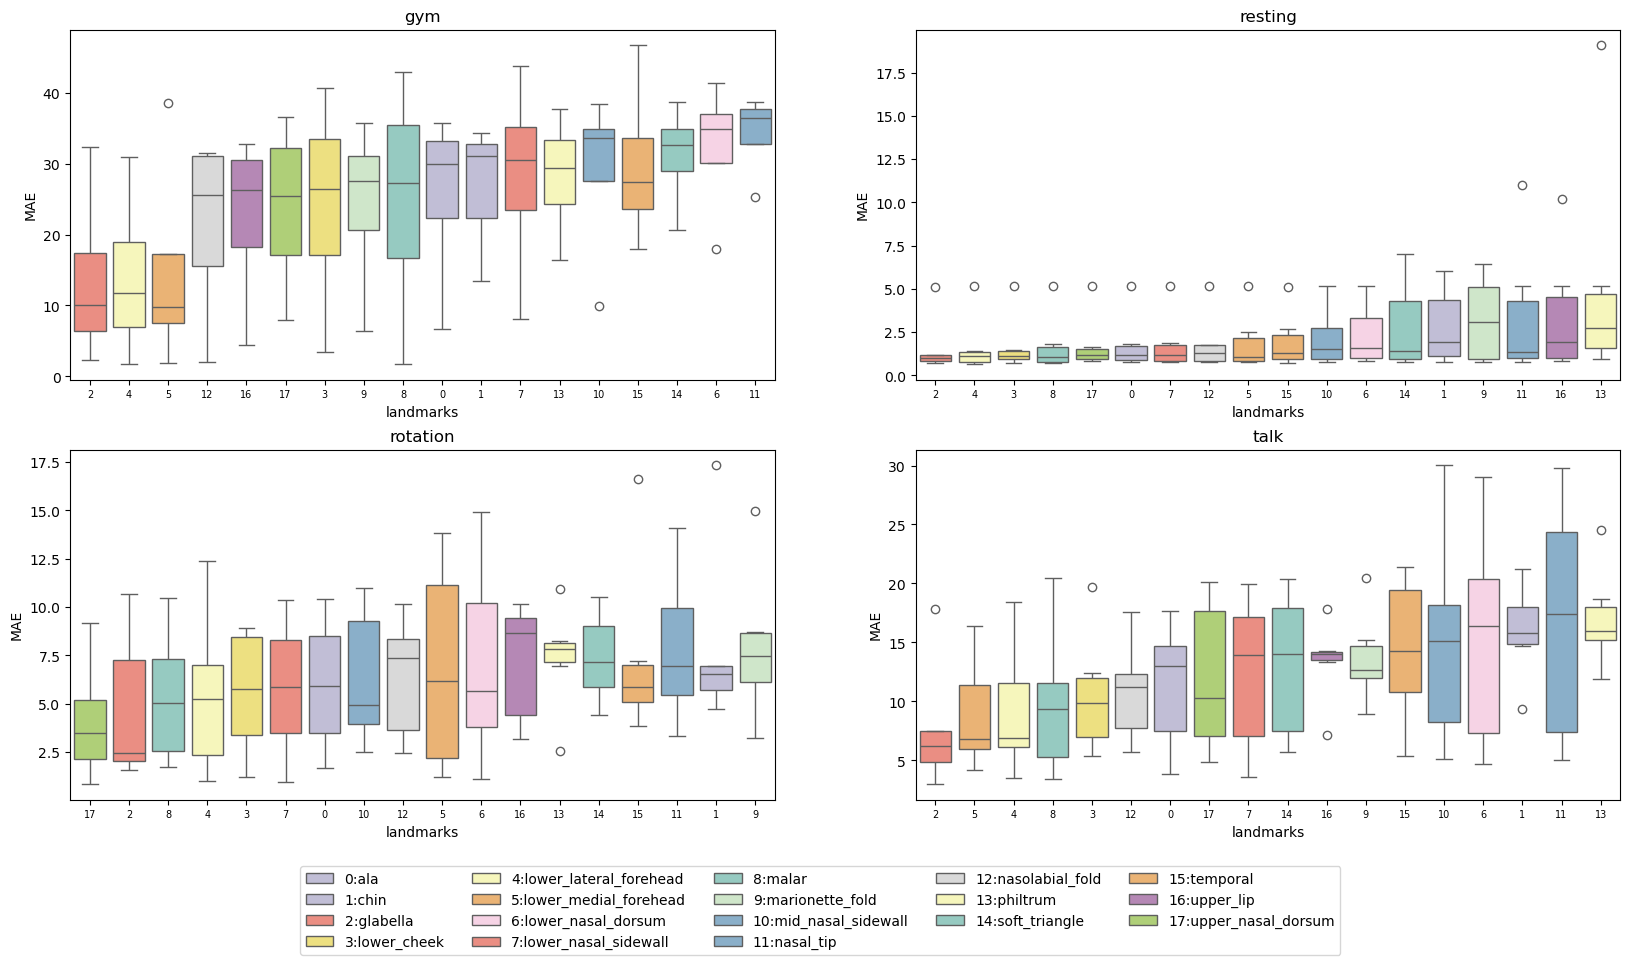

In [14]:
df['landmarks_id'] = df['landmarks'].astype('category').cat.codes
landmarks_mapping = df[['landmarks','landmarks_id']].drop_duplicates().sort_values(by='landmarks_id')
landmarks_mapping = dict(zip(landmarks_mapping['landmarks'].values, landmarks_mapping['landmarks_id'].values))

fig, axs = plt.subplots(2,2, figsize=(20,10))
videos = df.video.unique()
for i,ax in zip(range(len(df.video.unique())), axs.ravel()):
   df_video = df.loc[df['video'] == videos[i]].copy()
   df_video = get_data_each_landmark(df_video, metric, dataset_name)
   _, box = plot_boxplot_each_landmark(df_video, metric, dataset_name, ax)
   old_labels = [item.get_text().replace(' ', '_')  for item in box.get_xticklabels()]
   new_labels = [landmarks_mapping[label] for label in old_labels]
   box.set_xticks(range(len(new_labels)))
   box.set_xticklabels(new_labels,rotation=0, fontsize=7)
   box.set(title=videos[i])
handles_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
handles = [None] * len(df['landmarks_id'].unique())
labels = [None] * len(df['landmarks_id'].unique())
for (handle_label) in handles_labels:
    for i,(h,l) in enumerate(zip(*handle_label)):
        if  handles[landmarks_mapping[l]] is None:
            handles[landmarks_mapping[l]] = h
            labels[landmarks_mapping[l]] = str(landmarks_mapping[l])+':'+l
fig.legend(handles,labels, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=5)
plt.show()

## Landmarks in ROI by video setting

In [19]:
rois = constants.get_rois()

df_each = pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_each_landmark.h5')

# this part is only for ROI by video setting part
df_each['landmarks'] = df_each['landmarks'].apply(lambda x: x[0])
df_each = df_each[~df_each['landmarks'].str.contains('left|right') == True] # don't take left or right as a single landmark
df_each['landmarks'] = df_each['landmarks'].apply(lambda x: tuple([x]))
df_each = df_each.query("method == 'cupy_CHROM'")

print(df_each.dataset.unique(), "landmarks: ",df_each.landmarks.unique().size)
df_each.head(1)

# df_each[df_each['landmarks'].apply(lambda x: 'chin' in x)].videoFilename.unique() # angelo gym missing (david gym for none)
# print(df_each.videoFilename.unique().size, df_each.dataset.unique())
# df_each.groupby('landmarks').videoFilename.unique().apply(lambda x: len(x)).sort_values(ascending=False) # chin is missing 1 video

['lgi_ppgi'] 8


,method,dataset,videoFilename,videoIdx,RMSE,MAE,PCC,CCC,SNR,MAX,...,DTW,bpmGT,bpmES,timeGT,timeES,TIME_REQUIREMENT,landmarks,ROI,video,person
0,cupy_CHROM,lgi_ppgi,alex_gym,0,[45.13572534866459],[38.65147485977564],[0.06502402100798046],[0.03230624429920144],[-7.057836037648555],[109.7392578125],...,None,"[101.0, 100.0, 97.0, 94.5, 93.0, 93.0, 93.0, 9...","[73.2421875, 52.001953125, 52.001953125, 75.80...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",235.538658,"(soft_triangle,)",nose,gym,alex


### Nose

In [25]:
df = pd.read_hdf(f'../results/test_landmarks/landmarks_within_nose/LGI_PPGI_rotation_nose.h5', key='df')
df['ROI'] = 'nose'
print(df.dataset.unique(), "landmarks: ",df.landmarks.unique().size)
df.head(1)

['lgi_ppgi_nose'] landmarks:  21


,method,dataset,videoIdx,videoFilename,RMSE,MAE,PCC,CCC,SNR,MAX,DTW,MAD,bpmGT,bpmES,timeGT,timeES,TIME_REQUIREMENT,landmarks
0,cupy_CHROM,lgi_ppgi_nose,2,alex_rotation,[4.5748339907963755],[2.902664412313433],[0.47144104490323235],[0.3167227385864613],[-0.5598206185247513],[18.2939453125],[149.1689453125],"[1.46484375, 12.8173828125, 14.2822265625, 17....","[67.0, 67.5, 68.5, 69.0, 69.5, 70.0, 69.5, 68....","[68.84765625, 67.0166015625, 67.3828125, 65.91...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",39.545573,"(left_lower_nasal_sidewall, left_mid_nasal_sid..."


### Forehead

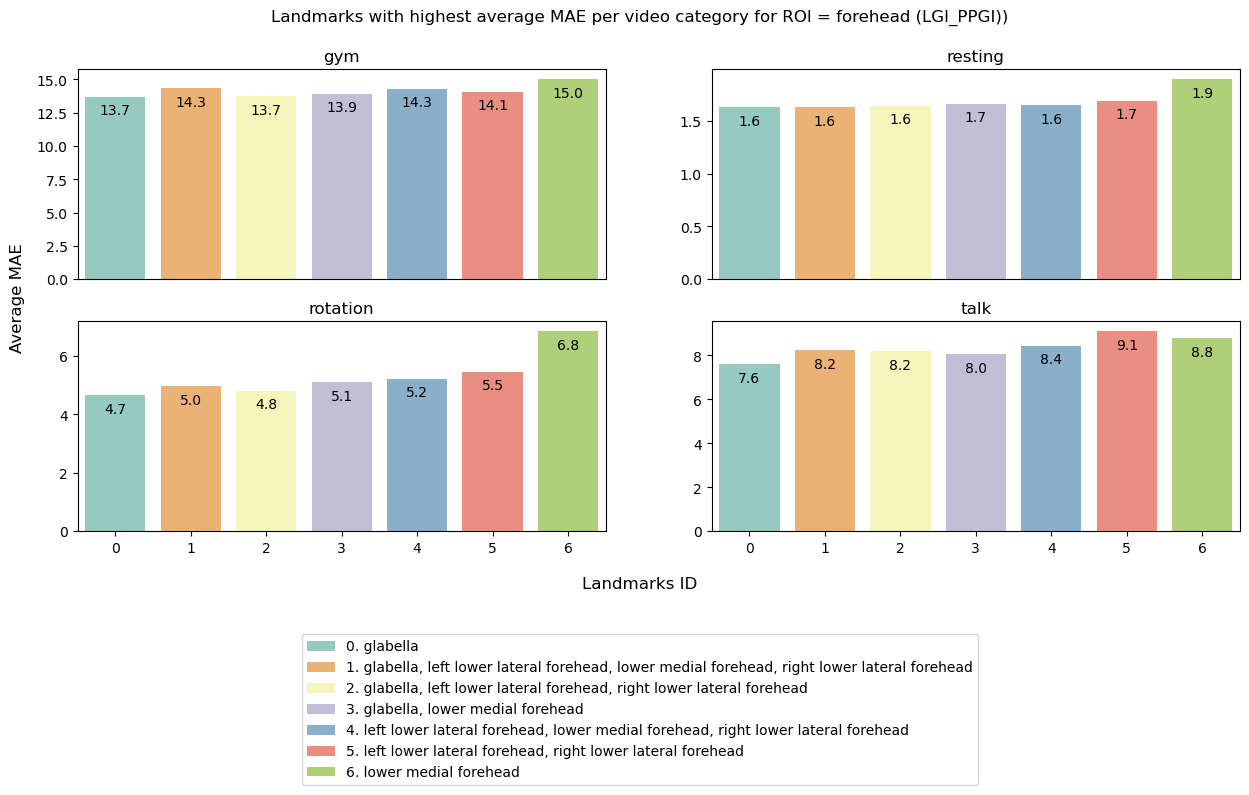

Median label: change from black to grey
Median label: change from black to grey
Median label: change from black to grey
Median label: change from black to grey


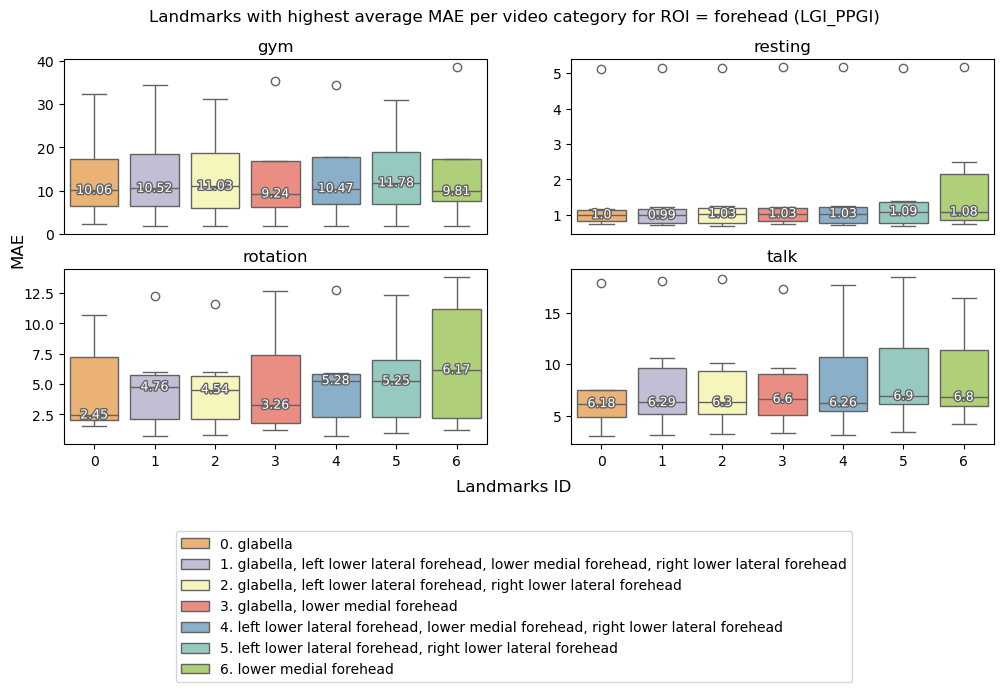

,method,dataset,videoFilename,landmarks,MAE,RMSE,PCC,video,score
150,cupy_CHROM,lgi_ppgi,harun_gym,"(lower_medial_forehead,)",38.528084,[46.33282551720361],[-0.09547763518838541],gym,15.008310
10,cupy_CHROM,lgi_ppgi,cpi_talk,"(left_lower_lateral_forehead, right_lower_late...",18.423089,[20.58029952542592],[0.054792670545679434],talk,9.098909
152,cupy_CHROM,lgi_ppgi,harun_rotation,"(lower_medial_forehead,)",13.811353,[19.756263650222348],[0.32196647549603136],rotation,6.842426
147,cupy_CHROM,lgi_ppgi,felix_resting,"(lower_medial_forehead,)",5.168046,[5.651127537134995],[-0.12108440018547151],resting,1.892529


In [17]:
roi = 'forehead'
df = pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_landmarks_in_roi.h5', key='df')\
        .query(f'ROI == "{roi}"')
# df = pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_{roi}.h5', key='df')
df = pd.concat([df, df_each.query(f'ROI == "{roi}"')]).reset_index(drop=True)    
metric = 'MAE'

df, rankings = get_rankings_roi(df, dataset_name, metric)
fig, axs = plt.subplots(2,2,figsize=(15,6))
fig, axs = plot_bar_roi(df, rankings, roi, dataset_name, ncol=2, fig=fig, axs=axs)
plt.show()

fig, axs = plt.subplots(2,2,figsize=(12,5))
fig, axs = plot_box_roi(df, rankings, roi, dataset_name, ncol=1, fig=fig, axs=axs)
plt.show()

df1, fig = plot_bubble_roi(df, metric, dataset_name, roi, size=[1100,400])
fig.show()

# print the worst video landmarks combination
df.sort_values('MAE',ascending=False).groupby('video').head(1)[['method','dataset','videoFilename','landmarks','MAE','RMSE','PCC','video','score']]

### Cheeks

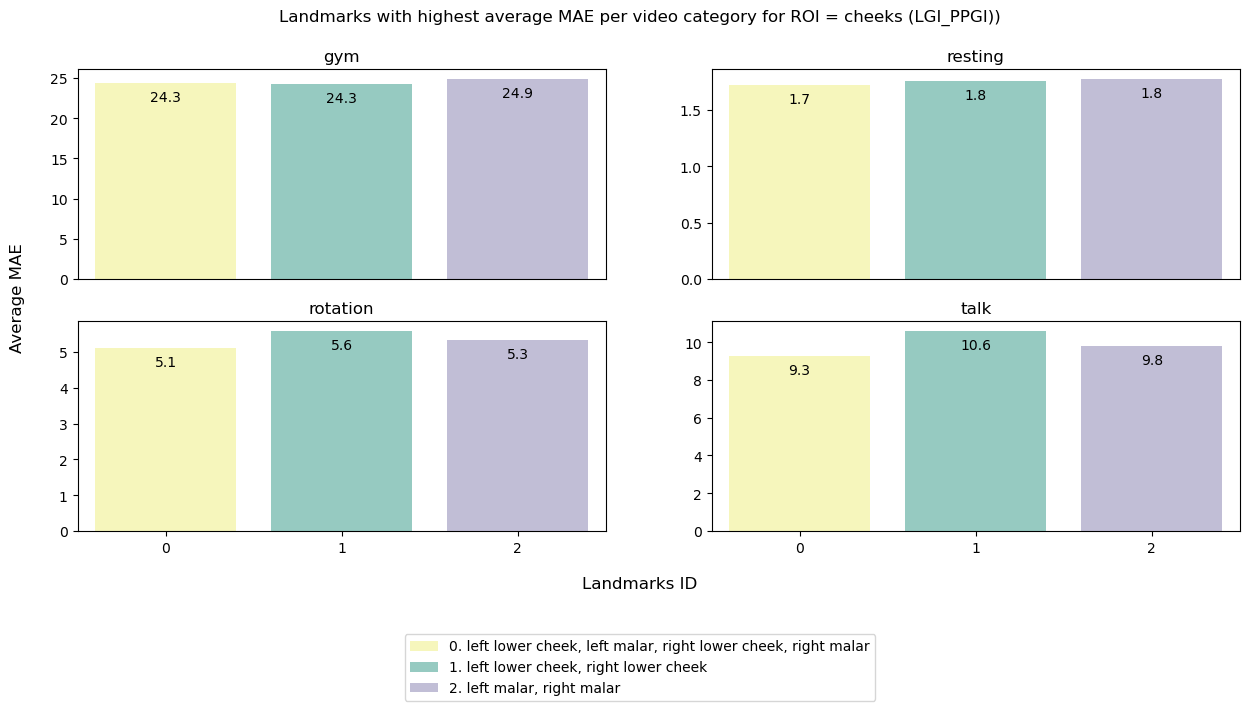

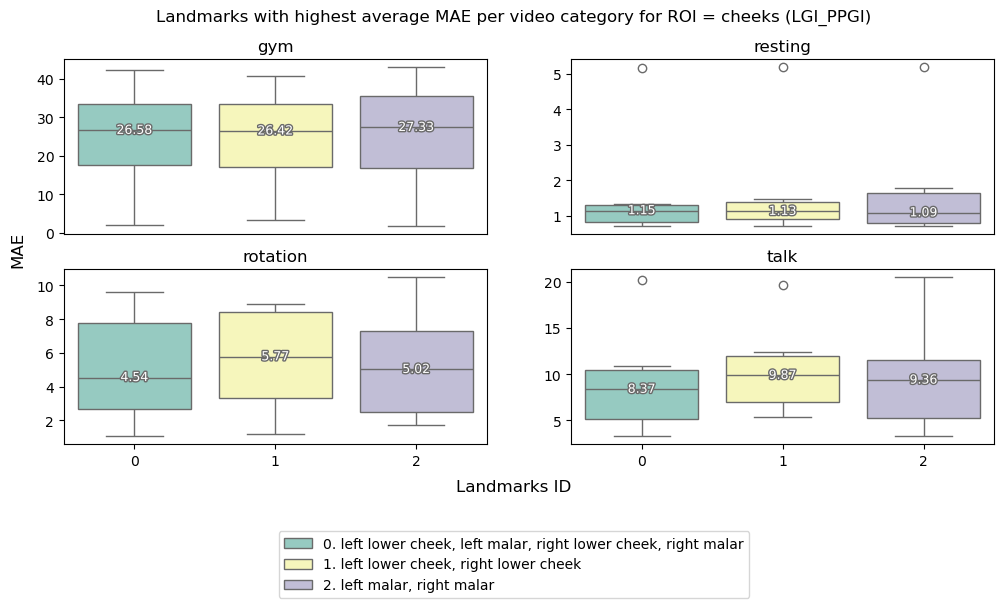

,method,dataset,videoFilename,landmarks,MAE,RMSE,PCC,video,score
62,cupy_CHROM,lgi_ppgi,harun_gym,"(left_malar, right_malar)",42.988406,[48.636273338497894],[-0.18886429496357304],gym,24.859581
54,cupy_CHROM,lgi_ppgi,cpi_talk,"(left_malar, right_malar)",20.491066,[22.81844853166723],[-0.2920563989806595],talk,9.804225
64,cupy_CHROM,lgi_ppgi,harun_rotation,"(left_malar, right_malar)",10.487398,[16.605842641588413],[0.09116715821148498],rotation,5.336010
59,cupy_CHROM,lgi_ppgi,felix_resting,"(left_malar, right_malar)",5.185485,[5.716188520045998],[-0.25630836913625593],resting,1.770368


In [12]:
roi = 'cheeks'
df = pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_landmarks_in_roi.h5', key='df')\
        .query(f'ROI == "{roi}"')
df = pd.concat([df, df_each.query(f'ROI == "{roi}"')]).reset_index(drop=True)    
metric = 'MAE'

df, rankings = get_rankings_roi(df, dataset_name, metric)
fig, axs = plt.subplots(2,2,figsize=(15,6))
fig, axs = plot_bar_roi(df, rankings, roi, dataset_name, ncol=2, fig=fig, axs=axs)
plt.show()

fig, axs = plt.subplots(2,2,figsize=(12,5))
fig, axs = plot_box_roi(df, rankings, roi, dataset_name, ncol=1, fig=fig, axs=axs)
plt.show()

df1, fig = plot_bubble_roi(df, metric, dataset_name, roi, size=[1000,400])
fig.show()

# print the worst video landmarks combination
df.sort_values('MAE',ascending=False).groupby('video').head(1)[['method','dataset','videoFilename','landmarks','MAE','RMSE','PCC','video','score']]

### Jaw

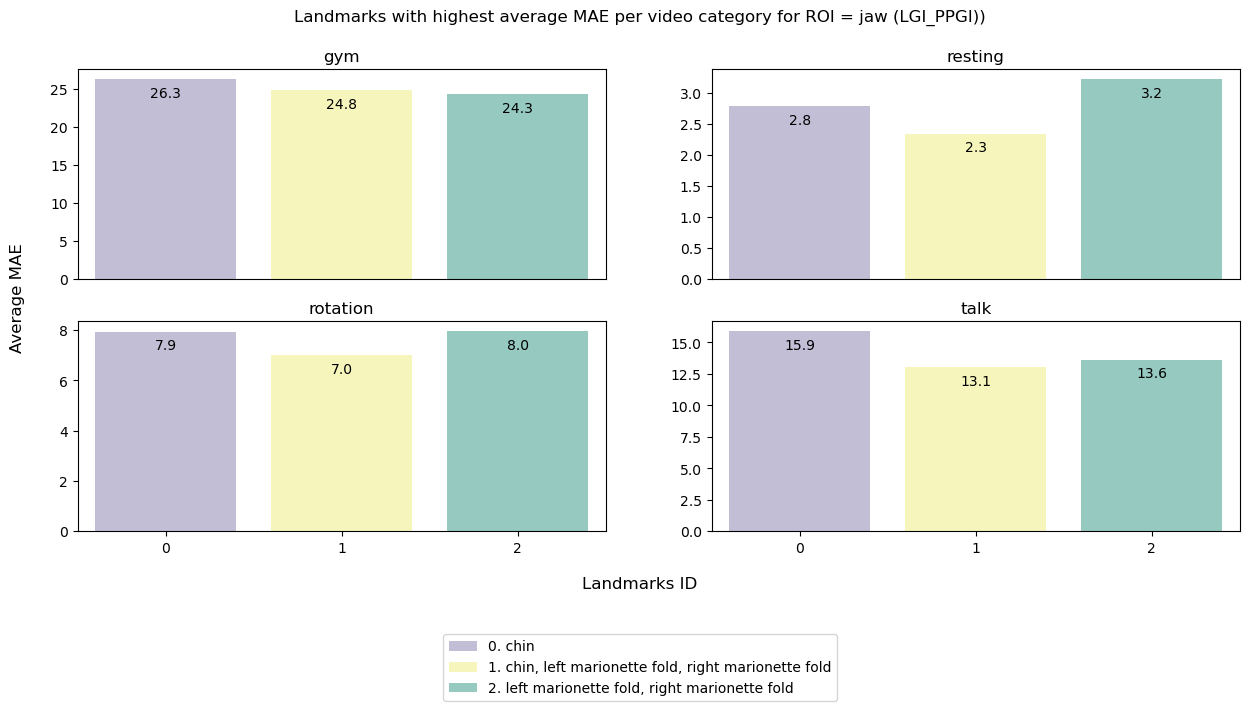

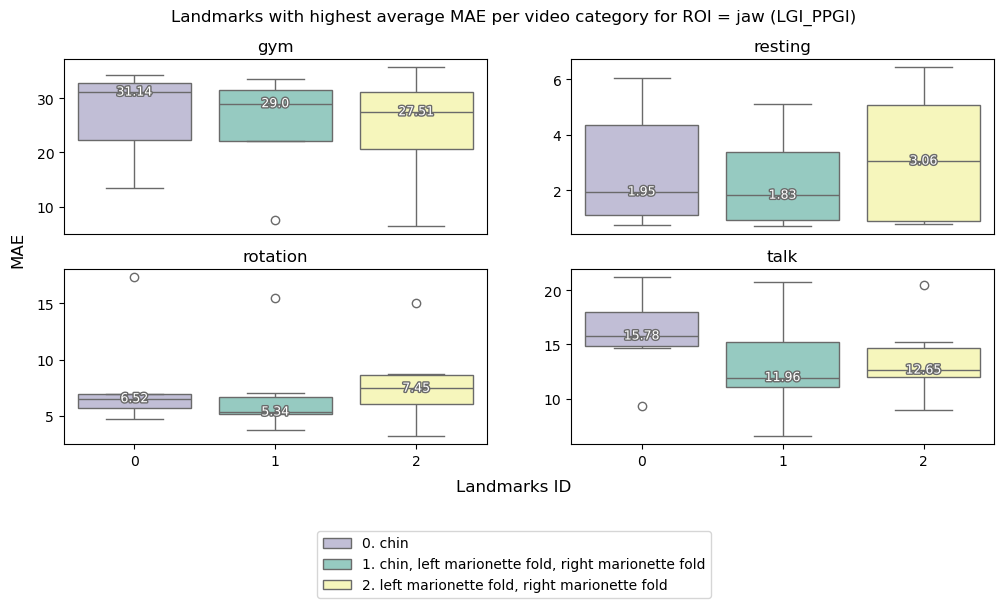

,method,dataset,videoFilename,landmarks,MAE,RMSE,PCC,video,score
40,cupy_CHROM,lgi_ppgi,harun_gym,"(left_marionette_fold, right_marionette_fold)",35.770439,[42.84291082362478],[-0.20902615648971937],gym,24.298186
54,CHROM,lgi_ppgi,cpi_talk,"(chin,)",21.203336,[23.617578886040153],[-0.0006737194256982264],talk,15.909625
63,CHROM,lgi_ppgi,harun_rotation,"(chin,)",17.331427,[22.095580961347945],[0.36432491022830943],rotation,7.938552
41,cupy_CHROM,lgi_ppgi,harun_resting,"(left_marionette_fold, right_marionette_fold)",6.441528,[11.93973096626907],[0.2915701910670221],resting,3.217260


In [12]:
roi = 'jaw'
df = pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_landmarks_in_roi.h5', key='df')\
        .query(f'ROI == "{roi}"')
df = pd.concat([df, df_each.query(f'ROI == "{roi}"')])\
        .query('videoFilename != "angelo_gym"').reset_index(drop=True)    
metric = 'MAE'

df, rankings = get_rankings_roi(df, dataset_name, metric)
fig, axs = plt.subplots(2,2,figsize=(15,6))
fig, axs = plot_bar_roi(df, rankings, roi, dataset_name, ncol=2, fig=fig, axs=axs)
plt.show()

fig, axs = plt.subplots(2,2,figsize=(12,5))
fig, axs = plot_box_roi(df, rankings, roi, dataset_name, ncol=1, fig=fig, axs=axs)
plt.show()

df1, fig = plot_bubble_roi(df, metric, dataset_name, roi, size=[1000,400])
fig.show()

# print the worst video landmarks combination
df.sort_values('MAE',ascending=False).groupby('video').head(1)[['method','dataset','videoFilename','landmarks','MAE','RMSE','PCC','video','score']]

### Mustache

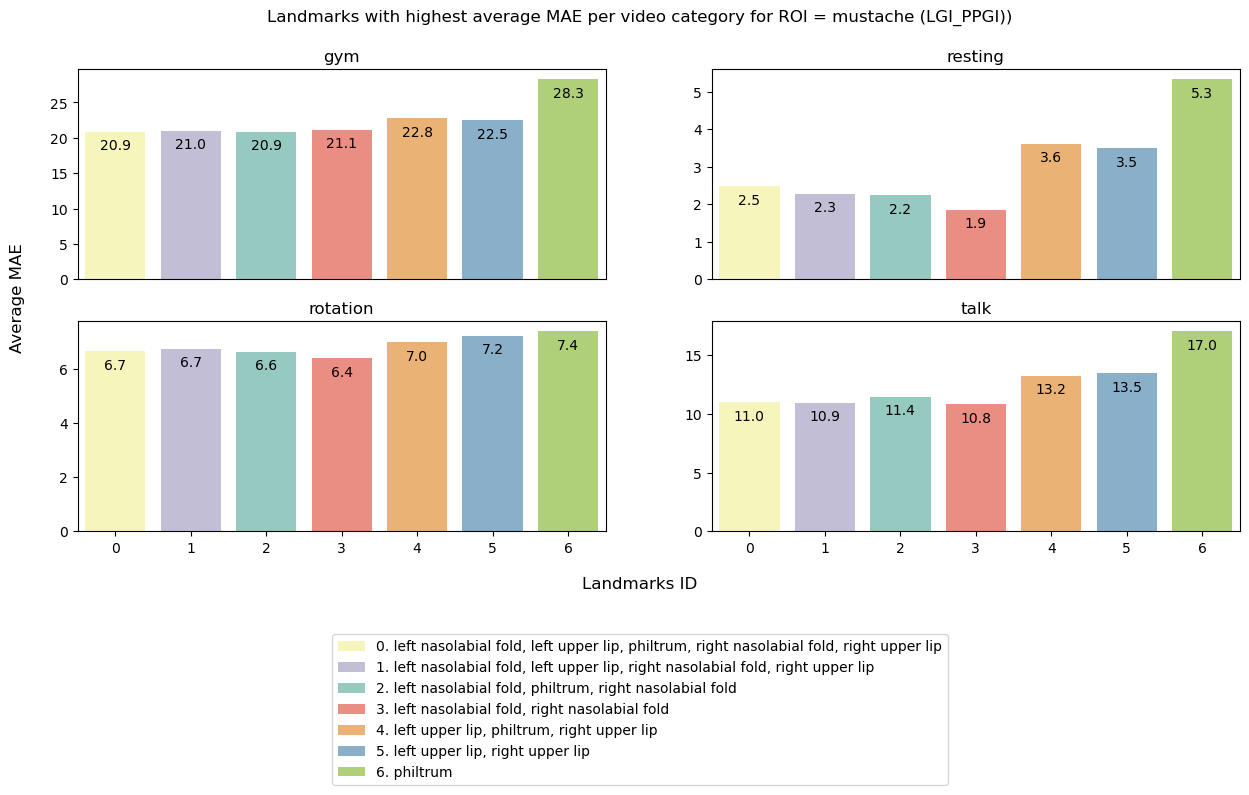

Median label: change from black to grey
Median label: change from black to grey
Median label: change from black to grey
Median label: change from black to grey


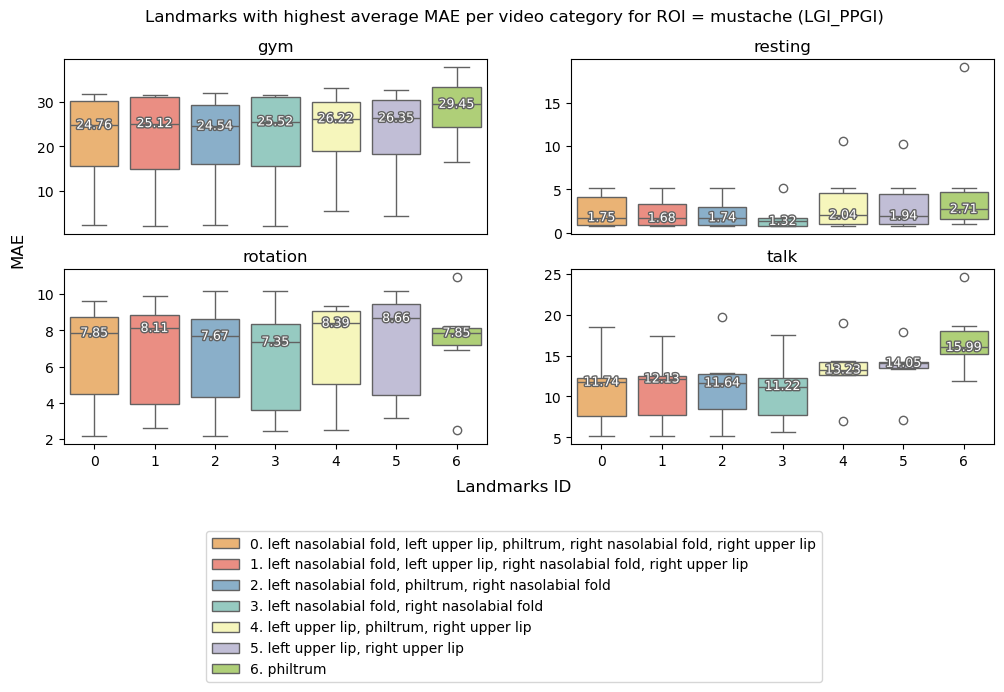

,method,dataset,videoFilename,landmarks,MAE,RMSE,PCC,video,score
132,cupy_CHROM,lgi_ppgi,alex_gym,"(philtrum,)",37.787700,[44.869430341628345],[0.03239095127312617],gym,28.278779
142,cupy_CHROM,lgi_ppgi,cpi_talk,"(philtrum,)",24.565456,[27.87259139705927],[-0.3501828958002106],talk,17.016830
144,cupy_CHROM,lgi_ppgi,david_resting,"(philtrum,)",19.066595,[30.68056262524544],[0.3161698063234311],resting,5.327971
145,cupy_CHROM,lgi_ppgi,david_rotation,"(philtrum,)",10.928760,[16.327019567715162],[0.3614178657627971],rotation,7.392440


In [13]:
roi = 'mustache'
df = pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_landmarks_in_roi.h5', key='df')\
        .query(f'ROI == "{roi}"')
df = pd.concat([df, df_each.query(f'ROI == "{roi}"')]).reset_index(drop=True)    
metric = 'MAE'

df, rankings = get_rankings_roi(df, dataset_name, metric)
fig, axs = plt.subplots(2,2,figsize=(15,6))
fig, axs = plot_bar_roi(df, rankings, roi, dataset_name, ncol=2, fig=fig, axs=axs)
plt.show()

fig, axs = plt.subplots(2,2,figsize=(12,5))
fig, axs = plot_box_roi(df, rankings, roi, dataset_name, ncol=1, fig=fig, axs=axs)
plt.show()

df1, fig = plot_bubble_roi(df, metric, dataset_name, roi, size=[1000,400])
fig.show()

# print the worst video landmarks combination
df.sort_values('MAE',ascending=False).groupby('video').head(1)[['method','dataset','videoFilename','landmarks','MAE','RMSE','PCC','video','score']]

## ROI combination

In [34]:
df = pd.read_hdf(f'../results/test_landmarks/LGI_PPGI_combine_
                 roi_nose_temple.h5', key='df')
print(df.ROI.unique().size, df.landmarks.unique().size)
# print(df.ROI.unique())
df.head(1)

45 45


,method,dataset,videoFilename,videoIdx,RMSE,MAE,PCC,CCC,SNR,MAX,MAD,DTW,bpmGT,bpmES,timeGT,timeES,TIME_REQUIREMENT,landmarks,ROI
0,cupy_CHROM,lgi_ppgi,alex_gym,0,[33.772696457296284],[24.909119591346155],[0.3687812669890864],[0.25950449494263234],[-5.899343169676379],[92.52734375],"[7.32421875, 3.662109375, 2.197265625, 14.6484...",[7723.71484375],"[101.0, 100.0, 97.0, 94.5, 93.0, 93.0, 93.0, 9...","[55.6640625, 54.931640625, 52.001953125, 62.98...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",226.964559,"(lower_medial_forehead, glabella, left_lower_l...",forehead_nose


In [19]:
print(df_combine.ROI.unique().size, df_combine.landmarks.unique().size)
print(df_combine.ROI.unique())

11 11
['forehead_cheeks' 'forehead_jaw' 'forehead_mustache' 'cheeks_jaw'
 'cheeks_mustache' 'jaw_mustache' 'forehead_cheeks_jaw'
 'forehead_cheeks_mustache' 'forehead_jaw_mustache' 'cheeks_jaw_mustache'
 'forehead_cheeks_jaw_mustache']


In [35]:
df_combine = pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_combine_roi.h5')
df = pd.read_hdf(f'../results/test_landmarks/LGI_PPGI_combine_roi_nose_temple.h5', key='df')
df_combine = pd.concat([df_combine, df]).reset_index(drop=True)

df1, fig = plot_bubble_roi(df_combine, metric, dataset_name, roi=None, title=f'MAE vs Time requirement for different ROI combinations ({dataset_name})',size=[800,400])
fig.show()

# MRI-NIRP

In [25]:
# -- LOAD A DATASET

dataset_name = 'MR_NIRP'    
video_DIR, BVP_DIR = constants.get_dataset_paths(dataset_name)

dataset = vhr.datasets.datasetFactory(dataset_name, videodataDIR=video_DIR, BVPdataDIR=BVP_DIR)
allvideo = dataset.videoFilenames
wsize = 8        # seconds of video processed (with overlapping) for each estimate 
fps = vhr.extraction.get_fps(dataset.getSigFilename(0))

# print the list of video names with the progressive index (idx)
for v in range(len(allvideo)):
  print(v, allvideo[v])

0 D:/datasets_rppg/MR-NIRP_indoor\Subject1_motion_940\Subject1_motion_940\RGB_corrected\Subject1_motion_940.avi
1 D:/datasets_rppg/MR-NIRP_indoor\Subject1_still_940-015\Subject1_still_940\RGB_corrected\Subject1_still_940.avi
2 D:/datasets_rppg/MR-NIRP_indoor\Subject2_motion_940\Subject2_motion_940\RGB_corrected\Subject2_motion_940.avi
3 D:/datasets_rppg/MR-NIRP_indoor\Subject2_still_940-002\Subject2_still_940\RGB_corrected\Subject2_still_940.avi
4 D:/datasets_rppg/MR-NIRP_indoor\Subject3_motion_940\Subject3_motion_940\RGB_corrected\Subject3_motion_940.avi
5 D:/datasets_rppg/MR-NIRP_indoor\Subject3_still_940-012\Subject3_still_940\RGB_corrected\Subject3_still_940.avi
6 D:/datasets_rppg/MR-NIRP_indoor\Subject4_motion_940\Subject4_motion_940\RGB_corrected\Subject4_motion_940.avi
7 D:/datasets_rppg/MR-NIRP_indoor\Subject4_still_940-004\Subject4_still_940\RGB_corrected\Subject4_still_940.avi
8 D:/datasets_rppg/MR-NIRP_indoor\Subject5_still_940-003\Subject5_still_940\RGB_corrected\Subject5_s

## Boxplot by landmark

Reding  ../results/test_landmarks/h5/MR_NIRP/MR_NIRP_each_landmark.h5
18


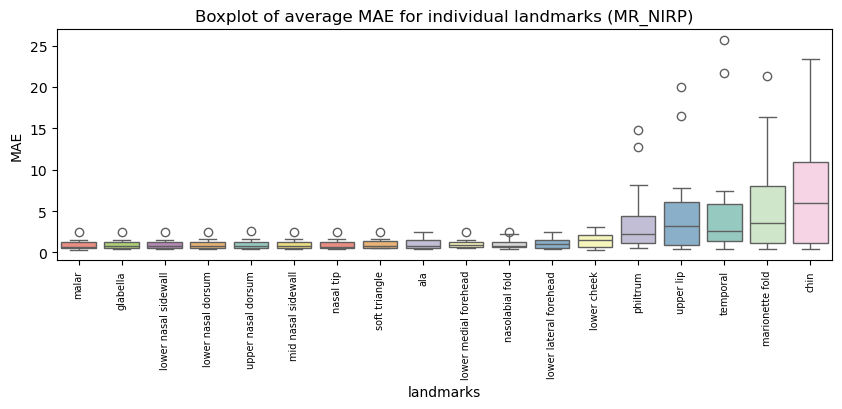

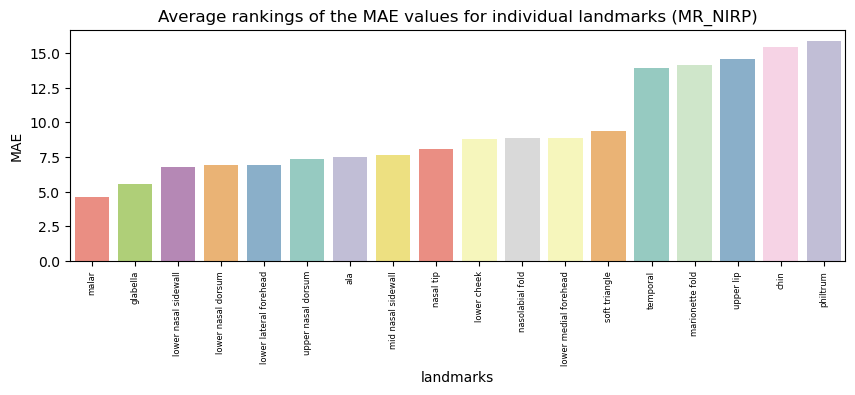

In [20]:
filenameH5 = f"../results/test_landmarks/h5/{dataset_name}/" + f"{dataset_name}_each_landmark" + ".h5"
metric = 'MAE'

print("Reding ", filenameH5)
df =  pd.read_hdf(filenameH5)
_, ax1 = plt.subplots(1,1, figsize=(10,3))
_, ax2 = plt.subplots(1,1, figsize=(10,3))
print(df.landmarks.unique().size)
df, grouped, rankings, box, bar = plot_each_landmark(df, metric, dataset_name, [ax1,ax2])

In [22]:
# Worst performing video on each video setting
df.sort_values('MAE', ascending=False).groupby('video').head(1)

,method,dataset,videoFilename,videoIdx,RMSE,MAE,PCC,CCC,SNR,MAX,...,DTW,bpmGT,bpmES,timeGT,timeES,TIME_REQUIREMENT,landmarks,ROI,video,person
180,cupy_CHROM,mr_nirp,Subject1_motion_940,0,[31.690865830405656],25.701744,[0.09335789382922287],[0.012342682562946712],[-3.6653637208429903],[69.51953125],...,[1408.97265625],"[72.0, 71.0, 67.5, 67.0, 70.0, 75.5, 78.0, 78....","[60.64453125, 88.76953125, 103.7109375, 116.45...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",46.063805,temporal,temple,motion,Subject1
181,cupy_CHROM,mr_nirp,Subject1_still_940,1,[27.628837322946726],21.740234,[0.06471538184062971],[0.007894306678561055],[-3.623597139146092],[84.673828125],...,[3523.197265625],"[76.0, 76.5, 77.0, 76.5, 76.0, 76.0, 76.0, 76....","[118.65234375, 95.361328125, 92.28515625, 95.8...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",126.728785,temporal,temple,still,Subject1


In [23]:
# With glabella and CHROM the results should be ok, lets look at the worst score
df.query("landmarks == 'glabella'").query('method == "cupy_CHROM"').sort_values('MAE', ascending=False).groupby('video').head(1)

,method,dataset,videoFilename,videoIdx,RMSE,MAE,PCC,CCC,SNR,MAX,...,DTW,bpmGT,bpmES,timeGT,timeES,TIME_REQUIREMENT,landmarks,ROI,video,person
100,cupy_CHROM,mr_nirp,Subject6_still_940,10,[3.5794018132565366],2.484396,[0.29531494630742383],[0.21339942852411273],[nan],[10.62890625],...,[254.39648437499994],"[45.5, 47.5, 54.0, 54.5, 55.0, 55.0, 55.499999...","[54.4921875, 54.4921875, 54.4921875, 54.492187...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",153.461391,glabella,forehead,still,Subject6
96,cupy_CHROM,mr_nirp,Subject4_motion_940,6,[2.4036987342950735],1.438802,[0.8491332262445875],[0.8473594672707601],[7.184540270655243],[8.158203125],...,[89.70117187500004],"[76.0, 75.5, 74.0, 72.5, 70.0, 66.0, 62.500000...","[70.3125, 65.478515625, 61.962890625, 61.52343...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",43.199564,glabella,forehead,motion,Subject4


## Individual landmarks by video setting

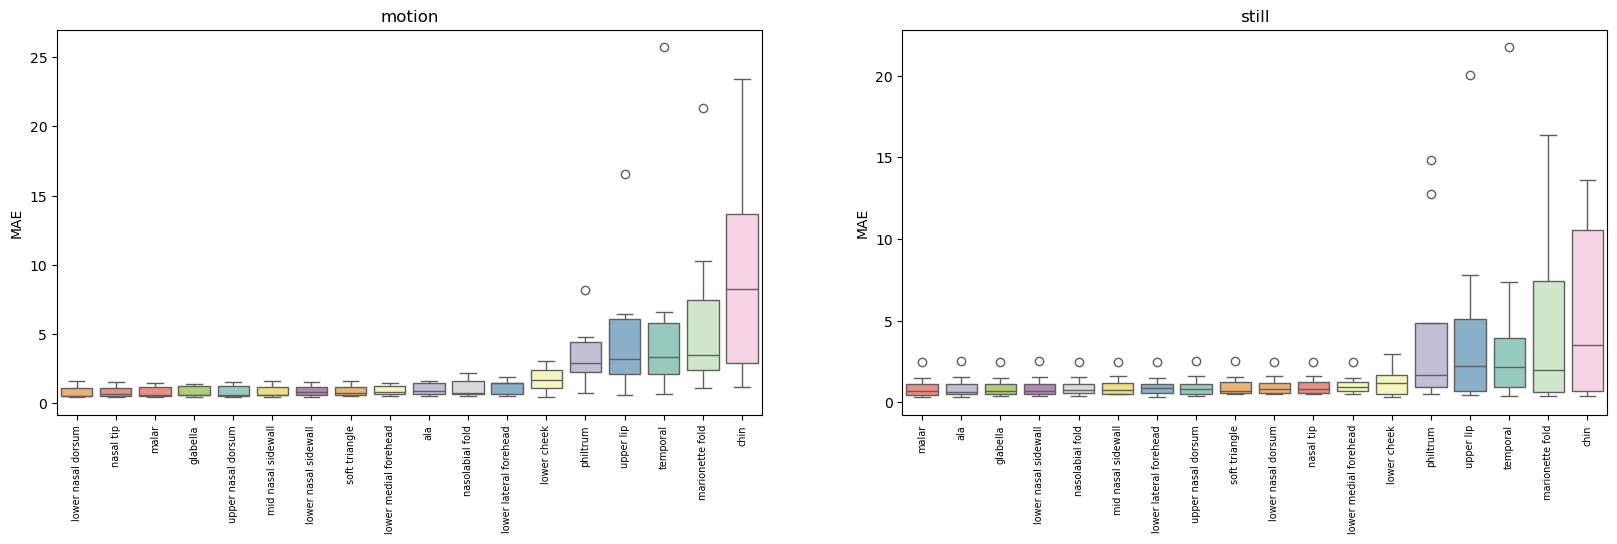

In [29]:
fig, axs = plt.subplots(1,2, figsize=(20,5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.6)
# fig.tight_layout()
videos = df.video.unique()
for i,ax in zip(range(len(df.video.unique())), axs.ravel()):
   df_video = df.loc[df['video'] == videos[i]].copy()
   df_video = get_data_each_landmark(df_video, metric, dataset_name)
   _, box = plot_boxplot_each_landmark(df_video, metric, dataset_name, ax)
   box.set(title=videos[i], xlabel=None)
plt.show()

## Landmarks in RIO by video setting

In [30]:
rois = constants.get_rois()

df_each = pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_each_landmark.h5')

# this part is only for ROI by video setting part
df_each['landmarks'] = df_each['landmarks'].apply(lambda x: x[0])
df_each = df_each[~df_each['landmarks'].str.contains('left|right') == True] # don't take left or right as a single landmark
df_each['landmarks'] = df_each['landmarks'].apply(lambda x: tuple([x]))
df_each = df_each.query("method == 'cupy_CHROM'")

print(df_each.dataset.unique(), "landmarks: ",df_each.landmarks.unique().size)
df_each.head(1)

# df_each[df_each['landmarks'].apply(lambda x: 'chin' in x)].videoFilename.unique() # angelo gym missing (david gym for none)
# print(df_each.videoFilename.unique().size, df_each.dataset.unique())
# df_each.groupby('landmarks').videoFilename.unique().apply(lambda x: len(x)).sort_values(ascending=False) # chin is missing 1 video

['mr_nirp'] landmarks:  8


,method,dataset,videoFilename,videoIdx,RMSE,MAE,PCC,CCC,SNR,MAX,MAD,DTW,bpmGT,bpmES,timeGT,timeES,TIME_REQUIREMENT,landmarks,ROI
0,cupy_CHROM,mr_nirp,Subject1_motion_940,0,[1.974431501312688],[1.0424299568965518],[0.8106410267062507],[0.7909698467225462],[1.7849326349297088],[9.958984375],"[0.87890625, 1.318359375, 0.439453125, 0.43945...",[60.23046875],"[72.0, 71.0, 67.5, 67.0, 70.0, 75.5, 78.0, 78....","[68.5546875, 76.025390625, 79.541015625, 79.98...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",53.031112,"(upper_nasal_dorsum,)",nose


### Forehead

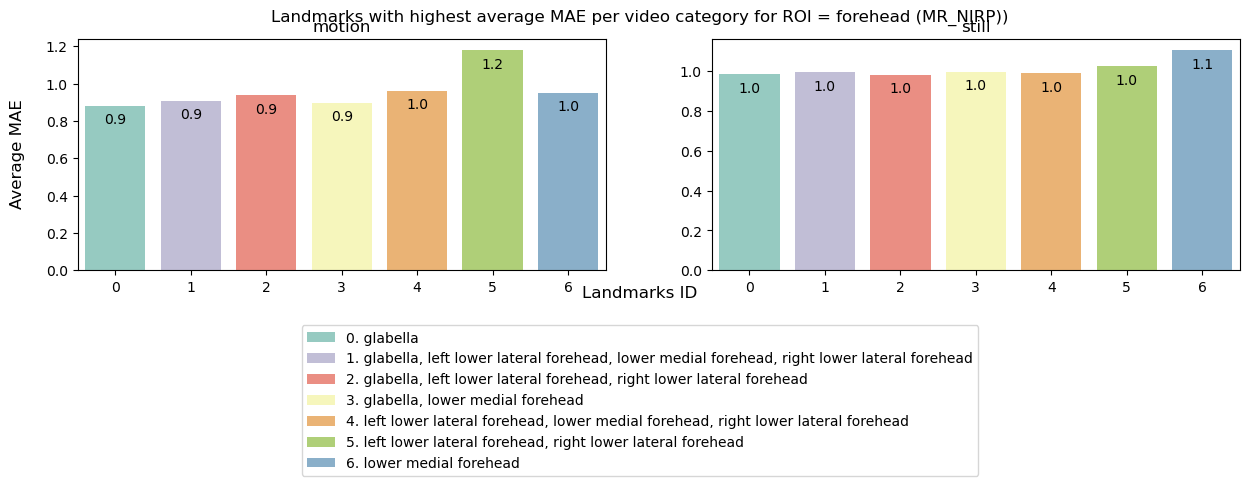

Median label: change from black to grey
Median label: change from black to grey


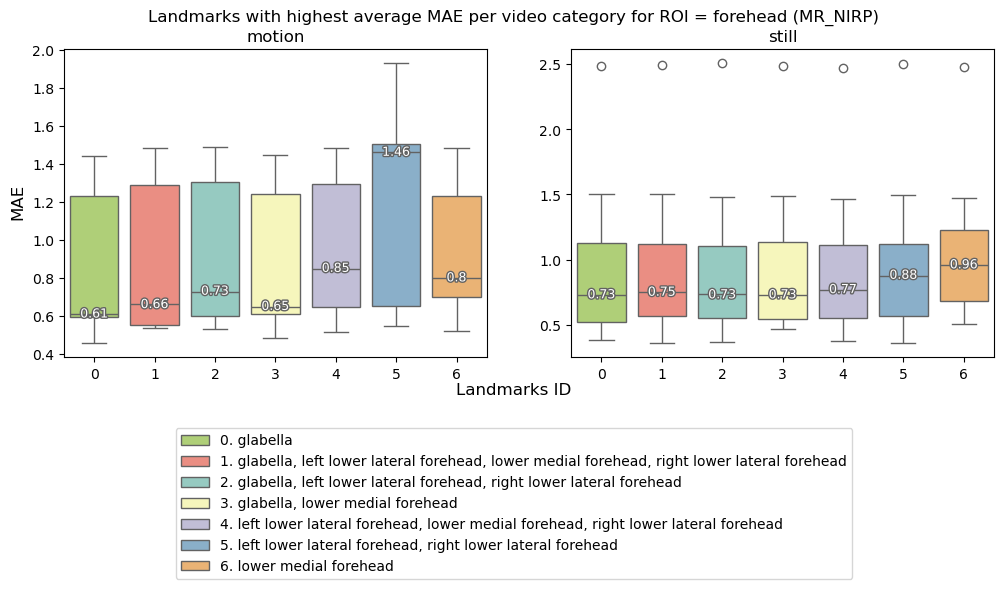

,method,dataset,videoFilename,landmarks,MAE,RMSE,PCC,video,score
10,cupy_CHROM,mr_nirp,Subject6_still_940,"(glabella, left_lower_lateral_forehead, right_...",2.506794,[3.5879640860807016],[0.2963296510886998],still,0.982475
73,cupy_CHROM,mr_nirp,Subject8_motion_940,"(left_lower_lateral_forehead, right_lower_late...",1.927919,[5.400910058366144],[0.599633410423806],motion,1.178129


In [ ]:
roi = 'forehead'
df = pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_landmarks_in_roi.h5', key='df')\
        .query(f'ROI == "{roi}"')
# df = pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_{roi}.h5', key='df')
df = pd.concat([df, df_each.query(f'ROI == "{roi}"')]).reset_index(drop=True)    
metric = 'MAE'

df, rankings = get_rankings_roi(df, dataset_name, metric)
fig, axs = plt.subplots(1,2,figsize=(15,3))
fig, axs = plot_bar_roi(df, rankings, roi, dataset_name, ncol=2, fig=fig, axs=axs)
plt.show()

fig, axs = plt.subplots(1,2,figsize=(12,4))
fig, axs = plot_box_roi(df, rankings, roi, dataset_name, ncol=1, fig=fig, axs=axs)
plt.show()

df1, fig = plot_bubble_roi(df, metric, dataset_name, roi, size=[1200,400])
fig.show()

# print the worst video landmarks combination
df.sort_values('MAE',ascending=False).groupby('video').head(1)[['method','dataset','videoFilename','landmarks','MAE','RMSE','PCC','video','score']]

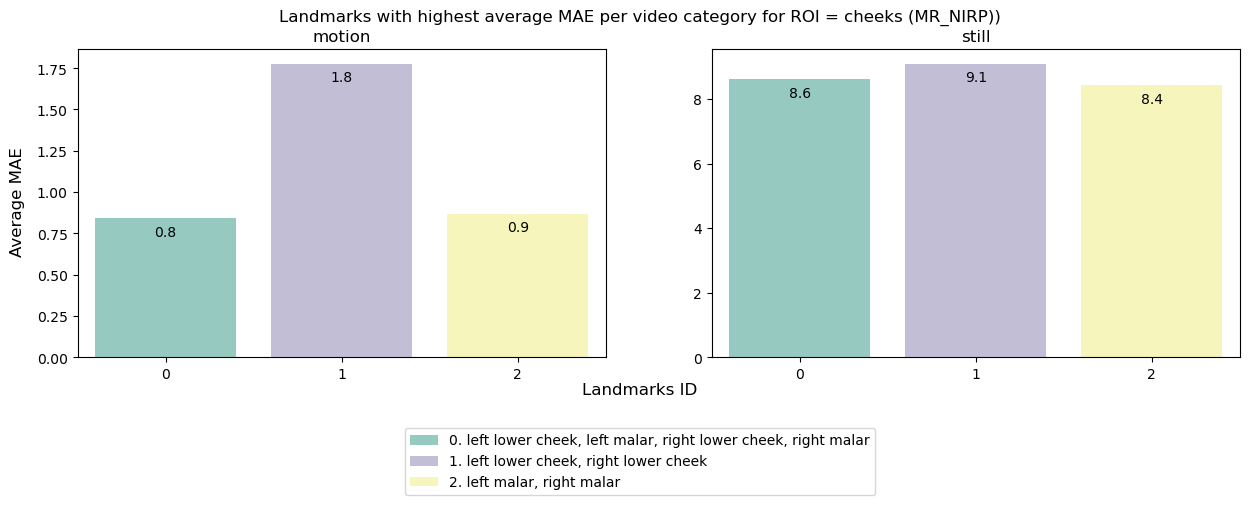

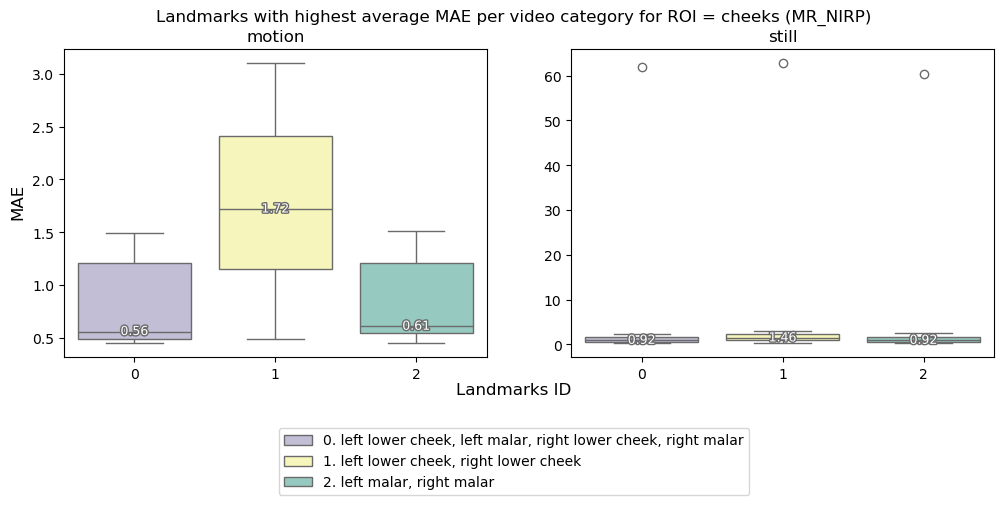

,method,dataset,videoFilename,landmarks,MAE,RMSE,PCC,video,score
18,cupy_CHROM,mr_nirp,Subject2_still_940,"(left_lower_cheek, right_lower_cheek)",62.785118,[65.19479363459641],[0.16176320852589116],still,9.093183
15,cupy_CHROM,mr_nirp,Subject1_motion_940,"(left_lower_cheek, right_lower_cheek)",3.101529,[5.3269160161723486],[0.3773749763666305],motion,1.776647


In [ ]:
roi = 'cheeks'
df = pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_landmarks_in_roi.h5', key='df')\
        .query(f'ROI == "{roi}"')
# df = pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_{roi}.h5', key='df')
df = pd.concat([df, df_each.query(f'ROI == "{roi}"')]).reset_index(drop=True)    
metric = 'MAE'

df, rankings = get_rankings_roi(df, dataset_name, metric)
fig, axs = plt.subplots(1,2,figsize=(15,4))
fig, axs = plot_bar_roi(df, rankings, roi, dataset_name, ncol=2, fig=fig, axs=axs)
plt.show()

fig, axs = plt.subplots(1,2,figsize=(12,4))
fig, axs = plot_box_roi(df, rankings, roi, dataset_name, ncol=1, fig=fig, axs=axs)
plt.show()

df1, fig = plot_bubble_roi(df, metric, dataset_name, roi, size=[800,400])
fig.show()


# print the worst video landmarks combination
df.sort_values('MAE',ascending=False).groupby('video').head(1)[['method','dataset','videoFilename','landmarks','MAE','RMSE','PCC','video','score']]

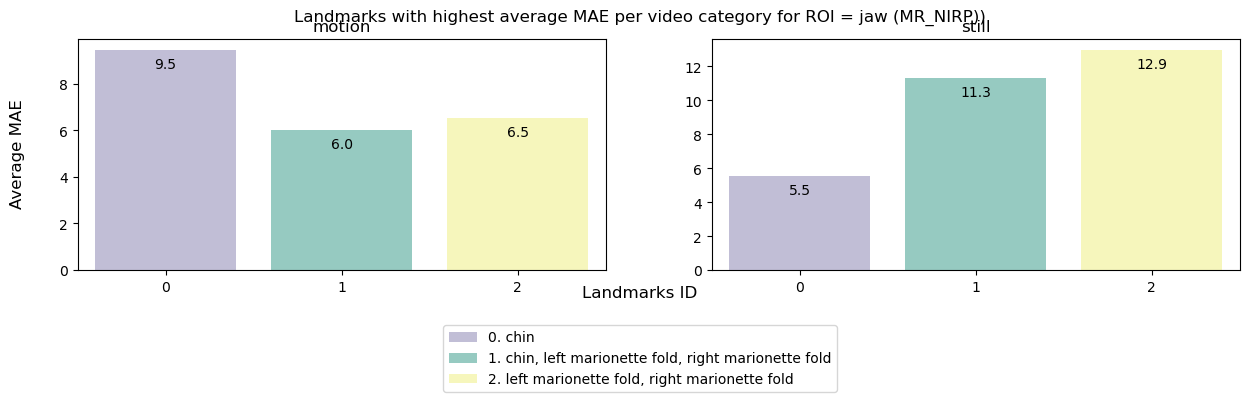

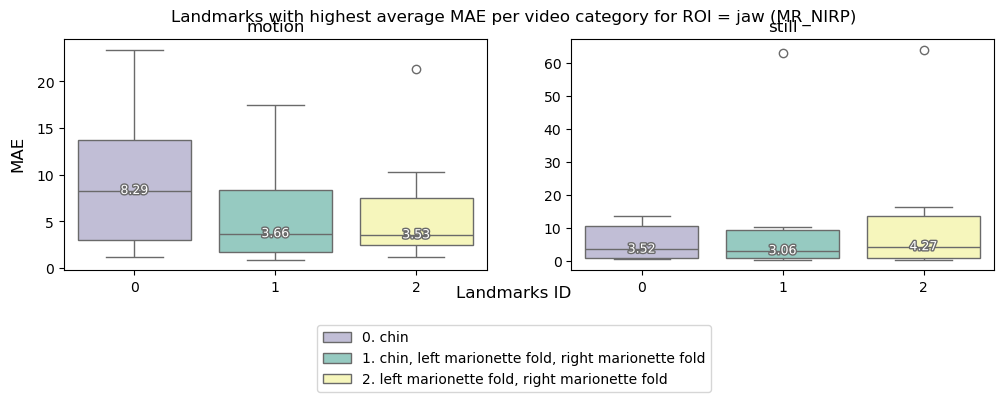

,method,dataset,videoFilename,landmarks,MAE,RMSE,PCC,video,score
18,cupy_CHROM,mr_nirp,Subject2_still_940,"(left_marionette_fold, right_marionette_fold)",63.984413,[67.47299296142866],[0.02139655270178253],still,12.948514
34,cupy_CHROM,mr_nirp,Subject3_motion_940,"(chin,)",23.429798,[29.9781966661305],[0.022167782833318432],motion,9.450695


In [ ]:
roi = 'jaw'
df = pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_landmarks_in_roi.h5', key='df')\
        .query(f'ROI == "{roi}"')
# df = pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_{roi}.h5', key='df')
df = pd.concat([df, df_each.query(f'ROI == "{roi}"')]).reset_index(drop=True)    
metric = 'MAE'

df, rankings = get_rankings_roi(df, dataset_name, metric)
fig, axs = plt.subplots(1,2,figsize=(15,3))
fig, axs = plot_bar_roi(df, rankings, roi, dataset_name, ncol=2, fig=fig, axs=axs)
plt.show()

fig, axs = plt.subplots(1,2,figsize=(12,3))
fig, axs = plot_box_roi(df, rankings, roi, dataset_name, ncol=1, fig=fig, axs=axs)
plt.show()

df1, fig = plot_bubble_roi(df, metric, dataset_name, roi, size=[800,400])
fig.show()


# print the worst video landmarks combination
df.sort_values('MAE',ascending=False).groupby('video').head(1)[['method','dataset','videoFilename','landmarks','MAE','RMSE','PCC','video','score']]

### Mustache

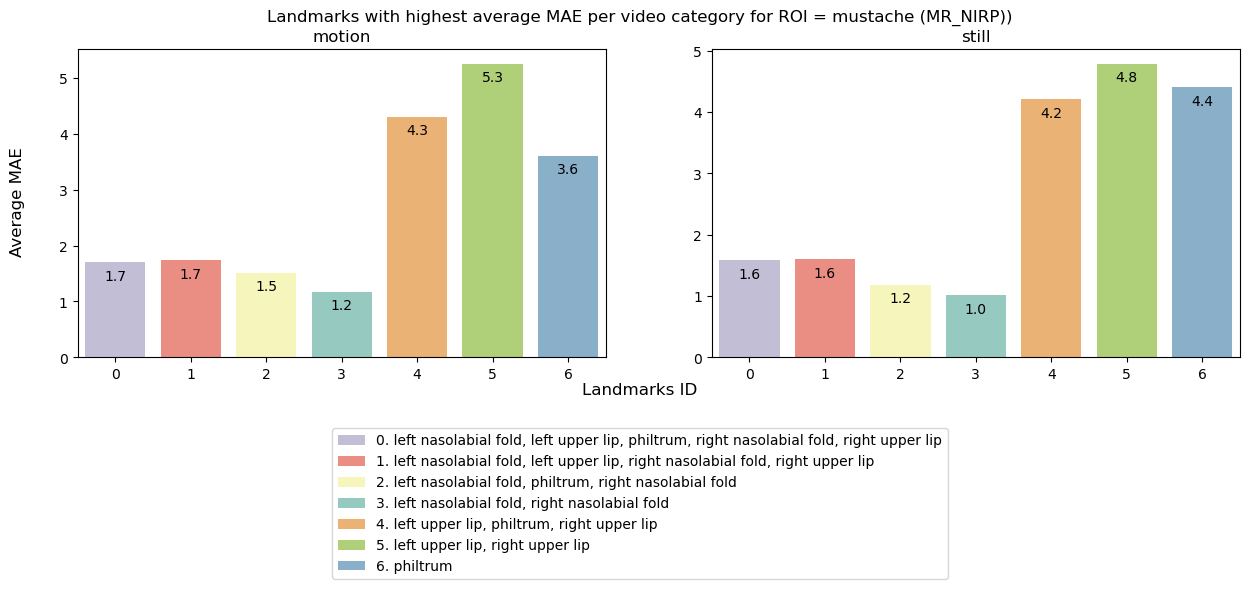

Median label: change from black to grey
Median label: change from black to grey


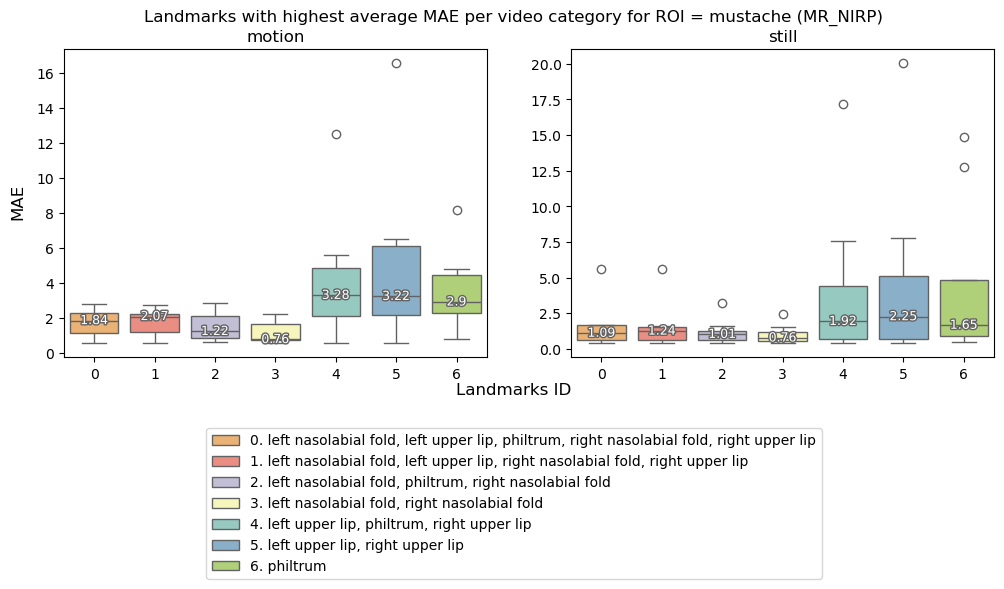

,method,dataset,videoFilename,landmarks,MAE,RMSE,PCC,video,score
70,cupy_CHROM,mr_nirp,Subject6_still_940,"(left_upper_lip, right_upper_lip)",20.042181,[26.731092169685606],[-0.016408615716110582],still,4.783056
69,cupy_CHROM,mr_nirp,Subject6_motion_940,"(left_upper_lip, right_upper_lip)",16.534493,[23.094319189022393],[-0.298000942439215],motion,5.255362


In [ ]:
roi = 'mustache'
df = pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_landmarks_in_roi.h5', key='df')\
        .query(f'ROI == "{roi}"')
# df = pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_{roi}.h5', key='df')
df = pd.concat([df, df_each.query(f'ROI == "{roi}"')]).reset_index(drop=True)    
metric = 'MAE'

df, rankings = get_rankings_roi(df, dataset_name, metric)
fig, axs = plt.subplots(1,2,figsize=(15,4))
fig, axs = plot_bar_roi(df, rankings, roi, dataset_name, ncol=2, fig=fig, axs=axs)
plt.show()

fig, axs = plt.subplots(1,2,figsize=(12,4))
fig, axs = plot_box_roi(df, rankings, roi, dataset_name, ncol=1, fig=fig, axs=axs)
plt.show()

df1, fig = plot_bubble_roi(df, metric, dataset_name, roi, size=[1000,400])
fig.show()


# print the worst video landmarks combination
df.sort_values('MAE',ascending=False).groupby('video').head(1)[['method','dataset','videoFilename','landmarks','MAE','RMSE','PCC','video','score']]
df.sort_values('MAE',ascending=False).groupby('video').head(1)[['method','dataset','videoFilename','landmarks','MAE','RMSE','PCC','video','score']]

## ROI Combination

In [29]:
dataset_name = 'MR_NIRP'
df_combine = pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_combine_roi.h5')
df1, fig = plot_bubble_roi(df_combine, metric, dataset_name, roi=None, size=[800,400])
fig.show()

# Combine ROI TODO temple nose

In [46]:
datasets = ['MR_NIRP', 'LGI_PPGI']
df = pd.DataFrame()
for dataset_name in datasets:
    df = pd.concat([df, pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_combine_roi.h5')])
df = df.sort_values(by='landmarks').reset_index(drop=True)
print(df.shape, df.landmarks.unique().size, df.dataset.unique().size)
print(df.dataset.unique(), df.ROI.unique())
df.head(2)

(407, 19) 11 2
['lgi_ppgi' 'mr_nirp'] ['cheeks_jaw' 'cheeks_jaw_mustache' 'cheeks_mustache' 'jaw_mustache'
 'forehead_cheeks' 'forehead_cheeks_jaw' 'forehead_cheeks_jaw_mustache'
 'forehead_cheeks_mustache' 'forehead_jaw' 'forehead_jaw_mustache'
 'forehead_mustache']


,method,dataset,videoFilename,videoIdx,RMSE,MAE,PCC,CCC,SNR,MAX,MAD,DTW,bpmGT,bpmES,timeGT,timeES,TIME_REQUIREMENT,landmarks,ROI
0,cupy_CHROM,lgi_ppgi,cpi_talk,11.0,[22.69920449917635],[20.57515572212838],[-0.3033848084784519],[-0.04021496657833118],[-4.511903800271653],[35.80078125],"[8.4228515625, 8.056640625, 8.056640625, 4.394...",[1381.2333984375],"[71.0, 72.0, 73.5, 76.5, 80.5, 85.5, 89.5, 90....","[57.4951171875, 58.59375, 60.791015625, 62.255...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",43.427267,"(left_malar, right_malar, left_lower_cheek, ri...",cheeks_jaw
1,cupy_CHROM,mr_nirp,Subject1_motion_940,0.0,[3.4328111868141793],[2.2677464978448274],[0.5269467879398594],[0.49695626258333164],[-2.6910793652822234],[10.966796875],"[11.42578125, 13.623046875, 10.107421875, 6.59...",[102.451171875],"[72.0, 71.0, 67.5, 67.0, 70.0, 75.5, 78.0, 78....","[70.3125, 76.46484375, 79.1015625, 82.17773437...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",53.034149,"(left_malar, right_malar, left_lower_cheek, ri...",cheeks_jaw


In [26]:
df1, fig = plot_bubble_roi(df, metric, dataset_name, roi, title='Average MAE vs Time requirement for different ROI combinations (LGI-PPGI,MR-NIRP)',size=[1000,400])
fig.show()

# Combine landmarks within ROI 

In [53]:
datasets = ['MR_NIRP', 'LGI_PPGI']
df_each = pd.DataFrame()
for dataset_name in datasets:
    df_each = pd.concat([df_each, pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_each_landmark.h5')])
# this part is only for ROI by video setting part
df_each['landmarks'] = df_each['landmarks'].apply(lambda x: x[0])
df_each = df_each[~df_each['landmarks'].str.contains('left|right') == True] # don't take left or right as a single landmark since we're getting them later
df_each['landmarks'] = df_each['landmarks'].apply(lambda x: tuple([x]))
df_each = df_each.query("method == 'cupy_CHROM'")
df_each = df_each.reset_index(drop=True)

print(df_each.shape, df_each.landmarks.unique().size, df_each.dataset.unique().size)
print(df_each.dataset.unique(), df_each.landmarks.unique())
df_each.head(2)

(296, 21) 8 2
['mr_nirp' 'lgi_ppgi'] [('upper_nasal_dorsum',) ('lower_medial_forehead',) ('nasal_tip',)
 ('lower_nasal_dorsum',) ('glabella',) ('chin',) ('philtrum',)
 ('soft_triangle',)]


,method,dataset,videoFilename,videoIdx,RMSE,MAE,PCC,CCC,SNR,MAX,...,DTW,bpmGT,bpmES,timeGT,timeES,TIME_REQUIREMENT,landmarks,ROI,video,person
0,cupy_CHROM,mr_nirp,Subject1_motion_940,0,[1.974431501312688],[1.0424299568965518],[0.8106410267062507],[0.7909698467225462],[1.7849326349297088],[9.958984375],...,[60.23046875],"[72.0, 71.0, 67.5, 67.0, 70.0, 75.5, 78.0, 78....","[68.5546875, 76.025390625, 79.541015625, 79.98...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",53.031112,"(upper_nasal_dorsum,)",nose,NaN,NaN
1,cupy_CHROM,mr_nirp,Subject1_still_940,1,[1.40670528483867],[0.8698105922965116],[0.8397404955766097],[0.8363984709129004],[2.255447911068819],[8.322265625],...,[124.48828125],"[76.0, 76.5, 77.0, 76.5, 76.0, 76.0, 76.0, 76....","[77.34375, 77.34375, 76.46484375, 76.025390625...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",140.719461,"(upper_nasal_dorsum,)",nose,NaN,NaN


In [54]:
rois = ['forehead','jaw','cheeks','mustache']
df_all = df_each.copy()
metric = 'MAE'

for dataset in datasets:
    df_roi = pd.read_hdf(f'../results/test_landmarks/h5/{dataset}/{dataset}_landmarks_in_roi.h5', key='df') # combinations of landmarks in one ROI
    df_all = pd.concat([df_all, df_roi])
df_all = df_all.sort_values(by='landmarks').reset_index(drop=True)

print(df_all.shape, df_all.landmarks.unique().size, df_all.dataset.unique().size, df_all.videoFilename.unique().size,)
print(df_all.dataset.unique(), df_all.ROI.unique())
df_all.head(2)

(888, 21) 24 2 37
['lgi_ppgi' 'mr_nirp'] ['jaw' 'forehead' 'cheeks' 'mustache' 'nose']


,method,dataset,videoFilename,videoIdx,RMSE,MAE,PCC,CCC,SNR,MAX,...,DTW,bpmGT,bpmES,timeGT,timeES,TIME_REQUIREMENT,landmarks,ROI,video,person
0,cupy_CHROM,lgi_ppgi,alex_resting,1,[3.4251100484933428],[1.8147194602272723],[0.7070304689752651],[0.6895047597535094],[2.6385761012594835],[13.4541015625],...,None,"[68.5, 68.5, 68.0, 67.0, 67.0, 67.0, 67.0, 66....","[67.3828125, 67.3828125, 68.115234375, 67.3828...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",41.283159,"(chin,)",jaw,resting,alex
1,cupy_CHROM,mr_nirp,Subject1_still_940,1,[20.92357061984365],[13.630393804505815],[-0.03503769490957572],[-0.007013663256979299],[-2.9828047024048554],[87.826171875],...,[2162.123046875],"[76.0, 76.5, 77.0, 76.5, 76.0, 76.0, 76.0, 76....","[118.212890625, 117.7734375, 116.89453125, 96....","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",130.010954,"(chin,)",jaw,NaN,NaN


In [56]:
roi = rois[0]
df = df_all.query(f'ROI == "{roi}"').copy()
df = df.reset_index(drop=True)
df1, fig = plot_bubble_roi(df, metric, dataset_name, roi,
                                title=f'Average MAE vs Time requirement for different landmarks in ROI {roi} ({", ".join(datasets)})', size=[1200,400])
fig.show()

# fuck TODO add temple nose

In [69]:
# datasets = ['MR_NIRP', 'LGI_PPGI']
datasets = ['LGI_PPGI']

df_each = pd.DataFrame()
for dataset_name in datasets:
    df_each = pd.concat([df_each, pd.read_hdf(f'../results/test_landmarks/h5/{dataset_name}/{dataset_name}_each_landmark.h5')])
df_each = df_each[~((df_each['landmarks'].apply(lambda x: x[0]).str.contains('left|right') == True) & (df_each['ROI'] != 'temple'))] # Remove landmarks of type left_, right_
df_each = df_each.reset_index(drop=True)

print(df_each.shape, df_each.landmarks.unique().size, df_each.dataset.unique().size)
print(df_each.dataset.unique())
df_each.head(2)

df_all = df_each.copy()

for dataset in datasets:
    df_roi = pd.read_hdf(f'../results/test_landmarks/h5/{dataset}/{dataset}_landmarks_in_roi.h5', key='df') # combinations of landmarks in one ROI
    df_all = pd.concat([df_all, df_roi])


df_all = df_all.sort_values(by='landmarks').reset_index(drop=True)

print(df_all.shape, df_all.landmarks.unique().size, df_all.dataset.unique().size, df_all.videoFilename.unique().size,)
print(df_all.dataset.unique(), df_all.ROI.unique())
df_all.head(2)

(198, 21) 9 1
['lgi_ppgi']
(550, 21) 25 1 22
['lgi_ppgi'] ['jaw' 'forehead' 'cheeks' 'mustache' 'temple' 'nose']


,method,dataset,videoFilename,videoIdx,RMSE,MAE,PCC,CCC,SNR,MAX,...,DTW,bpmGT,bpmES,timeGT,timeES,TIME_REQUIREMENT,landmarks,ROI,video,person
0,cupy_CHROM,lgi_ppgi,harun_rotation,22,[22.095580961347945],[17.331426711309526],[0.36432491022830943],[0.07737408852541366],[-3.799572494084252],[54.927734375],...,None,"[87.5, 88.5, 90.5, 91.5, 90.5, 88.0, 85.0, 82....","[95.947265625, 98.14453125, 88.623046875, 113....","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",39.045168,"(chin,)",jaw,rotation,harun
1,cupy_CHROM,lgi_ppgi,alex_gym,0,[41.831244096347575],[34.31926081730769],[0.21356666703987653],[0.12035004052526053],[-6.479563282677331],[87.462890625],...,None,"[101.0, 100.0, 97.0, 94.5, 93.0, 93.0, 93.0, 9...","[81.298828125, 78.369140625, 53.466796875, 47....","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",221.429319,"(chin,)",jaw,gym,alex


In [79]:
palette = get_palette(df.sort_values(by=['ROI']), hue='ROI')
rgb_colors = [f'rgb({int(color[0]*255)},{int(color[1]*255)},{int(color[2]*255)})' for color in palette.values()] 
palette = dict(zip(df['ROI'].unique(), rgb_colors))

In [80]:
metric = 'MAE'
df = df_all.copy()
size = [1200,600]

if df[metric].dtype == 'object':
    df[metric] = df[metric].apply(lambda x: x[0])
if dataset_name == 'MR_NIRP':
    df['video'] = df.videoFilename.apply(lambda x: x.split('_')[1])
if dataset_name == 'LGI_PPGI':
    df['video'] = df['videoFilename'].apply(lambda x: x.split('_')[-1])
df['ldmk_time'] = df.groupby('landmarks')['TIME_REQUIREMENT'].transform('sum')
df['ldmk_MAE'] = df.groupby('landmarks')['MAE'].transform('mean')
df['ldmk_size'] = df['landmarks'].apply(lambda x: len(x))

df['landmarks'] = df.landmarks.apply(lambda x: ', '.join(x).replace('_',' ').replace('(','').replace(')',''))    

df['landmarks_id'] = df['landmarks'].astype('category').cat.codes
df['landmarks'] = df['landmarks_id'].astype('str') + ': ' + df['landmarks'] 
df = df.sort_values(by='landmarks_id').reset_index(drop=True)

fig = px.scatter(df, x="ROI", y="ldmk_MAE", color="landmarks", hover_data=['landmarks'], text='landmarks_id',
                template='none', color_discrete_sequence=px.colors.qualitative.Set2, width=size[0], height=size[1],
                labels={'ldmk_time':'Time requirement (s)', 'ldmk_MAE':'MAE (bpm)', 'landmarks':'Landmarks', 'ldmk_size':'Number of landmarks'},
                title=f"MAE for each ROI and different landmarks (LGI_PPGI, MR_NIRP)",) 
fig.update_traces(textposition='middle center', textfont_size=12, textfont_family='Courier New') 
fig.update_xaxes(showline=True, linecolor='black', mirror=True) # linewidth=2, 
fig.update_yaxes(showline=True, linecolor='black', mirror=True)
fig.show()

print("For mustahce, nasolabial fold is good")

For mustahce, nasolabial fold is good
